# Семинар 2

In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

# https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html

## STL-декомпозиция

In [93]:
from statsmodels.datasets import elec_equip

data = elec_equip.load().data.iloc[:, 0]
data.name = "Electrical equipment production"

data.head()


DATE
1995-01-01    66.19
1995-02-01    65.15
1995-03-01    74.48
1995-04-01    71.26
1995-05-01    67.63
Name: Electrical equipment production, dtype: float64

<Axes: xlabel='DATE'>

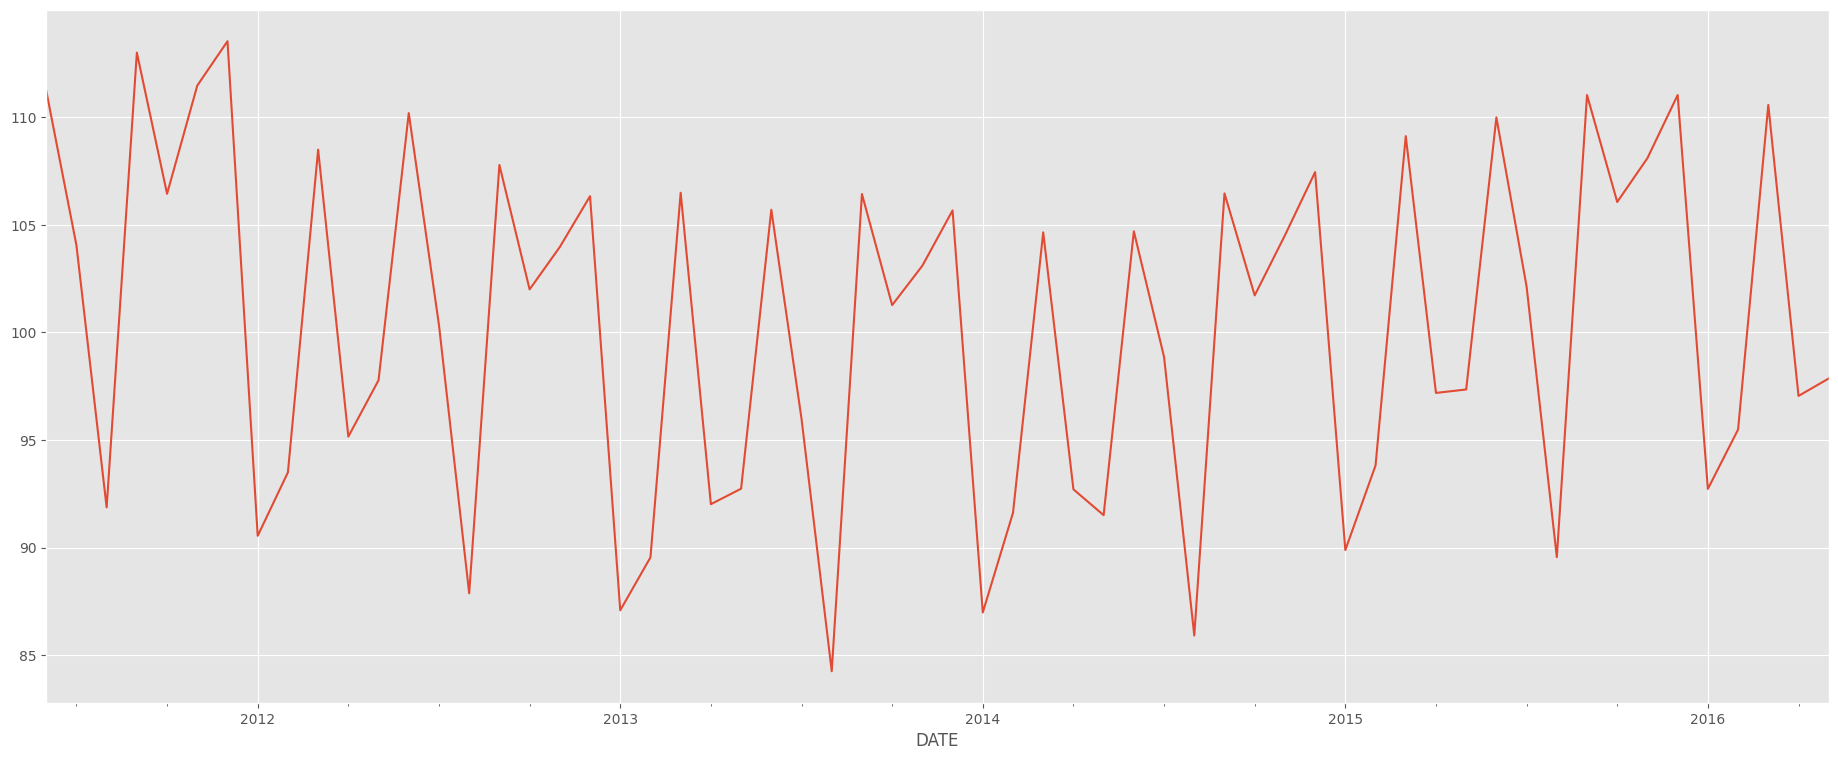

In [98]:
data.tail(60).plot()

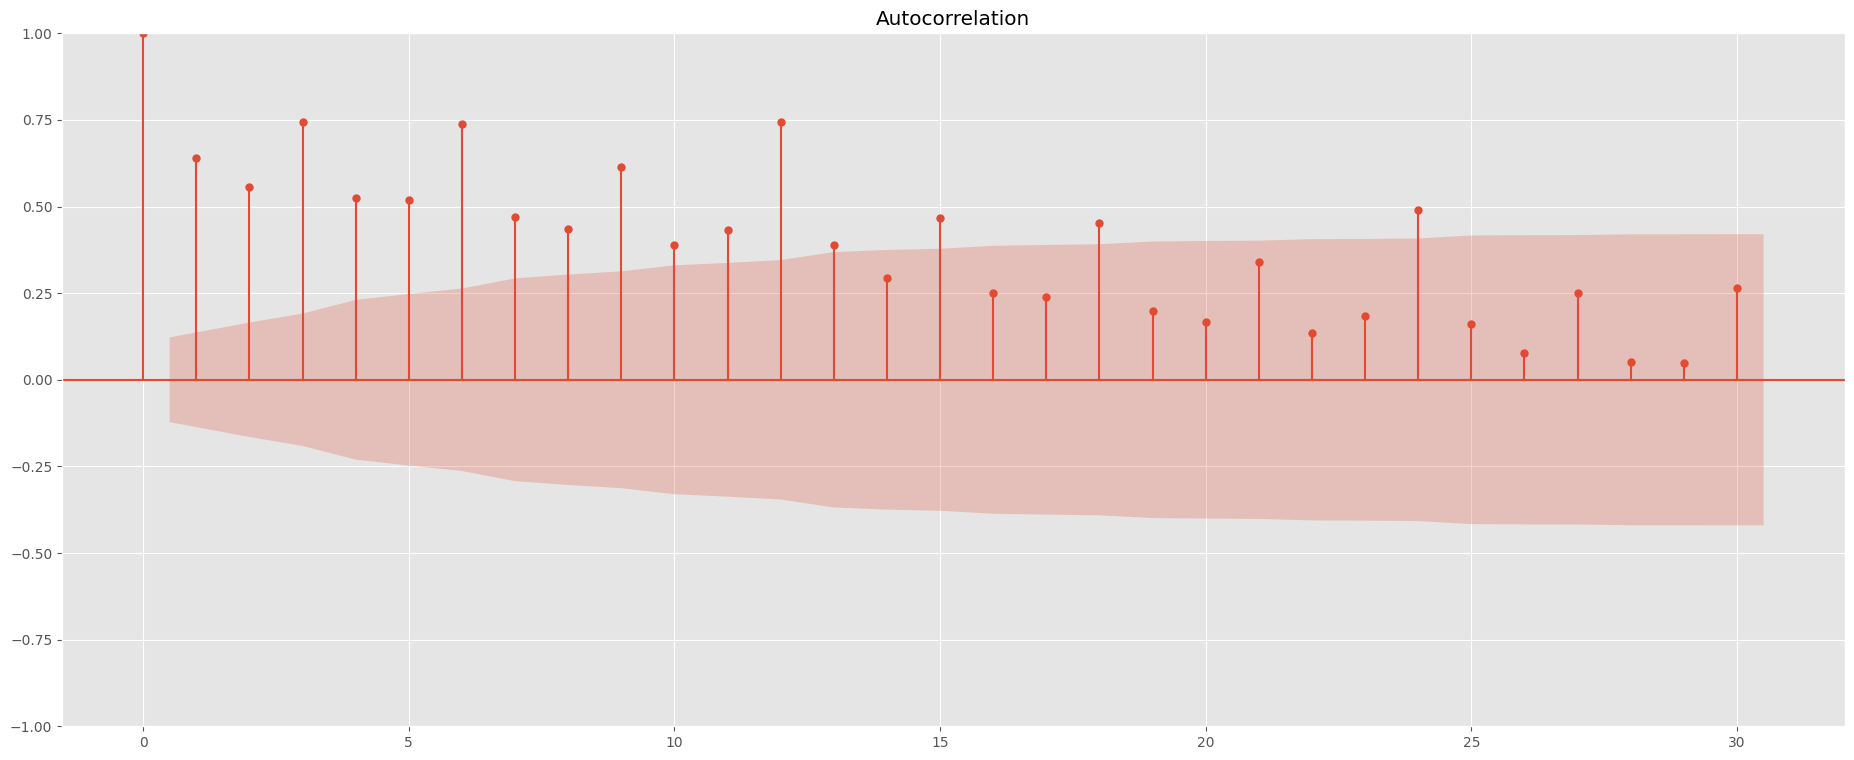

In [99]:
plot_acf(data, lags = 30);

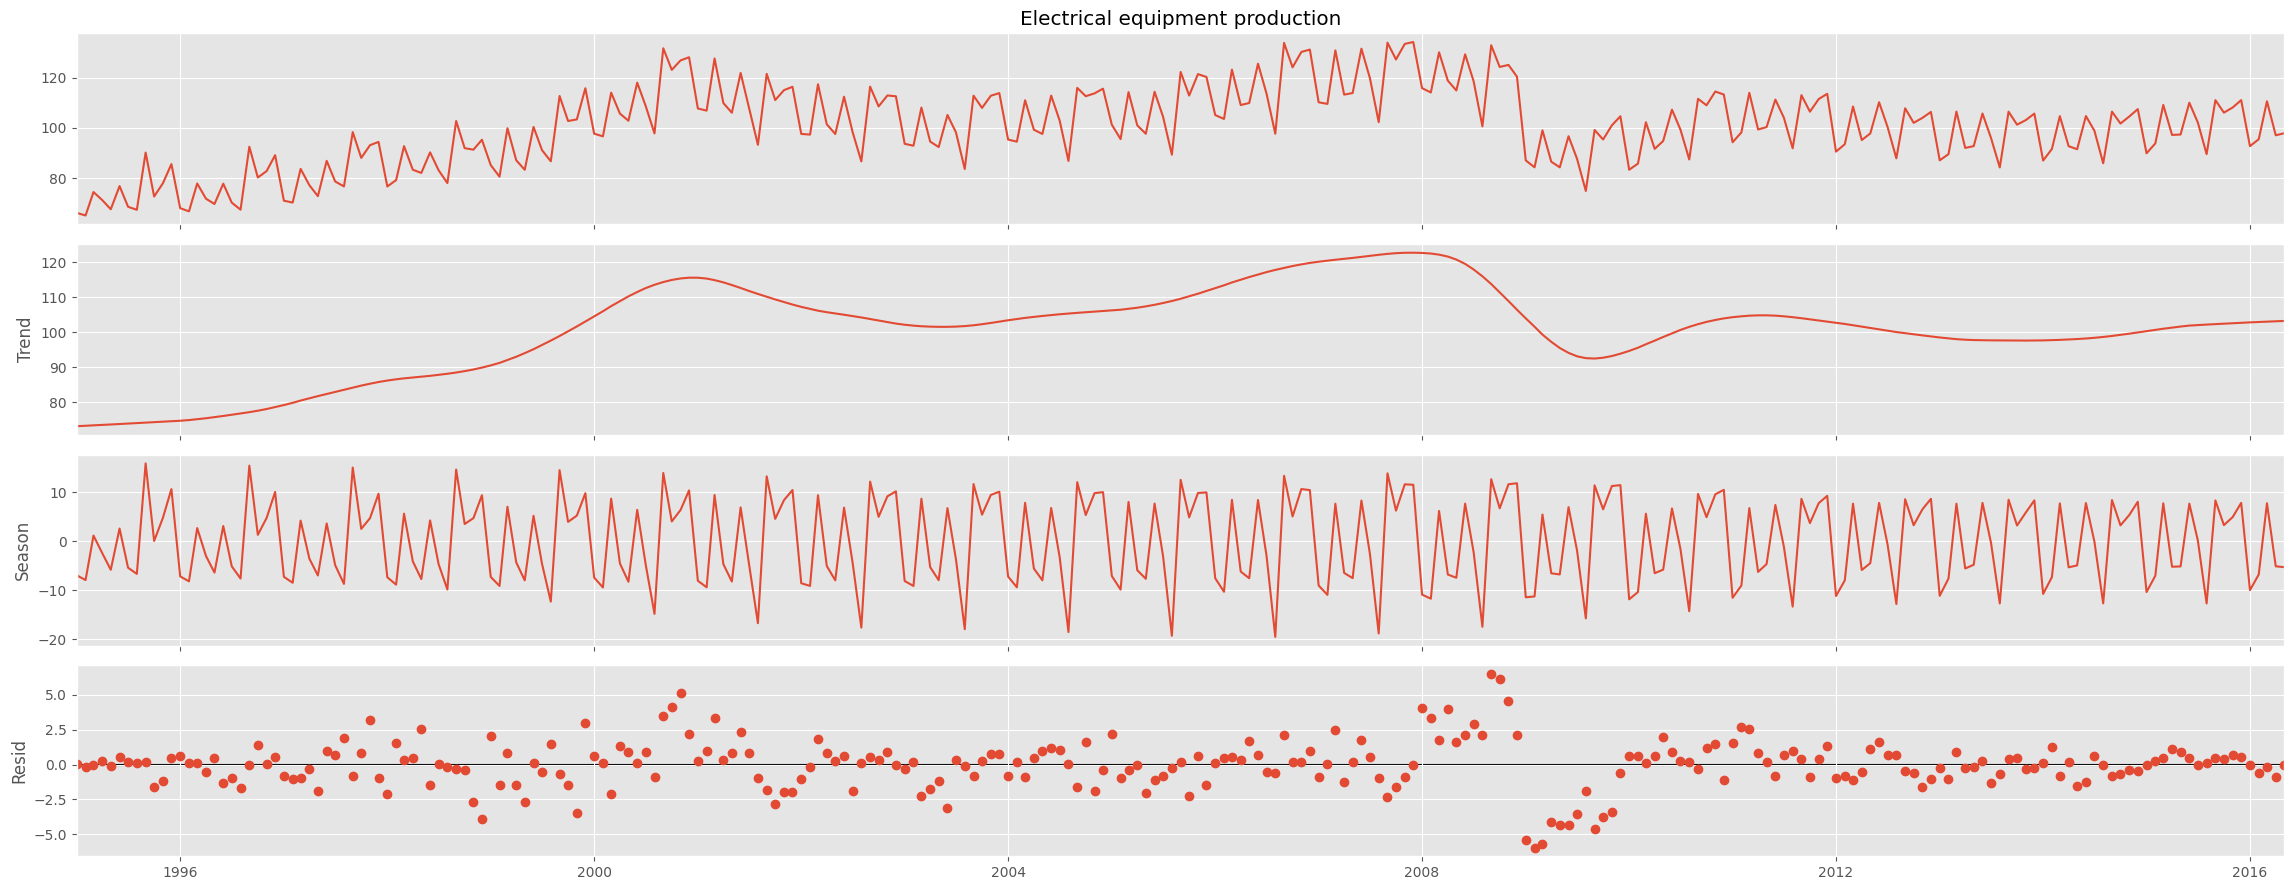

In [103]:
res = STL(data.dropna(), period=12).fit()
ax = res.plot()

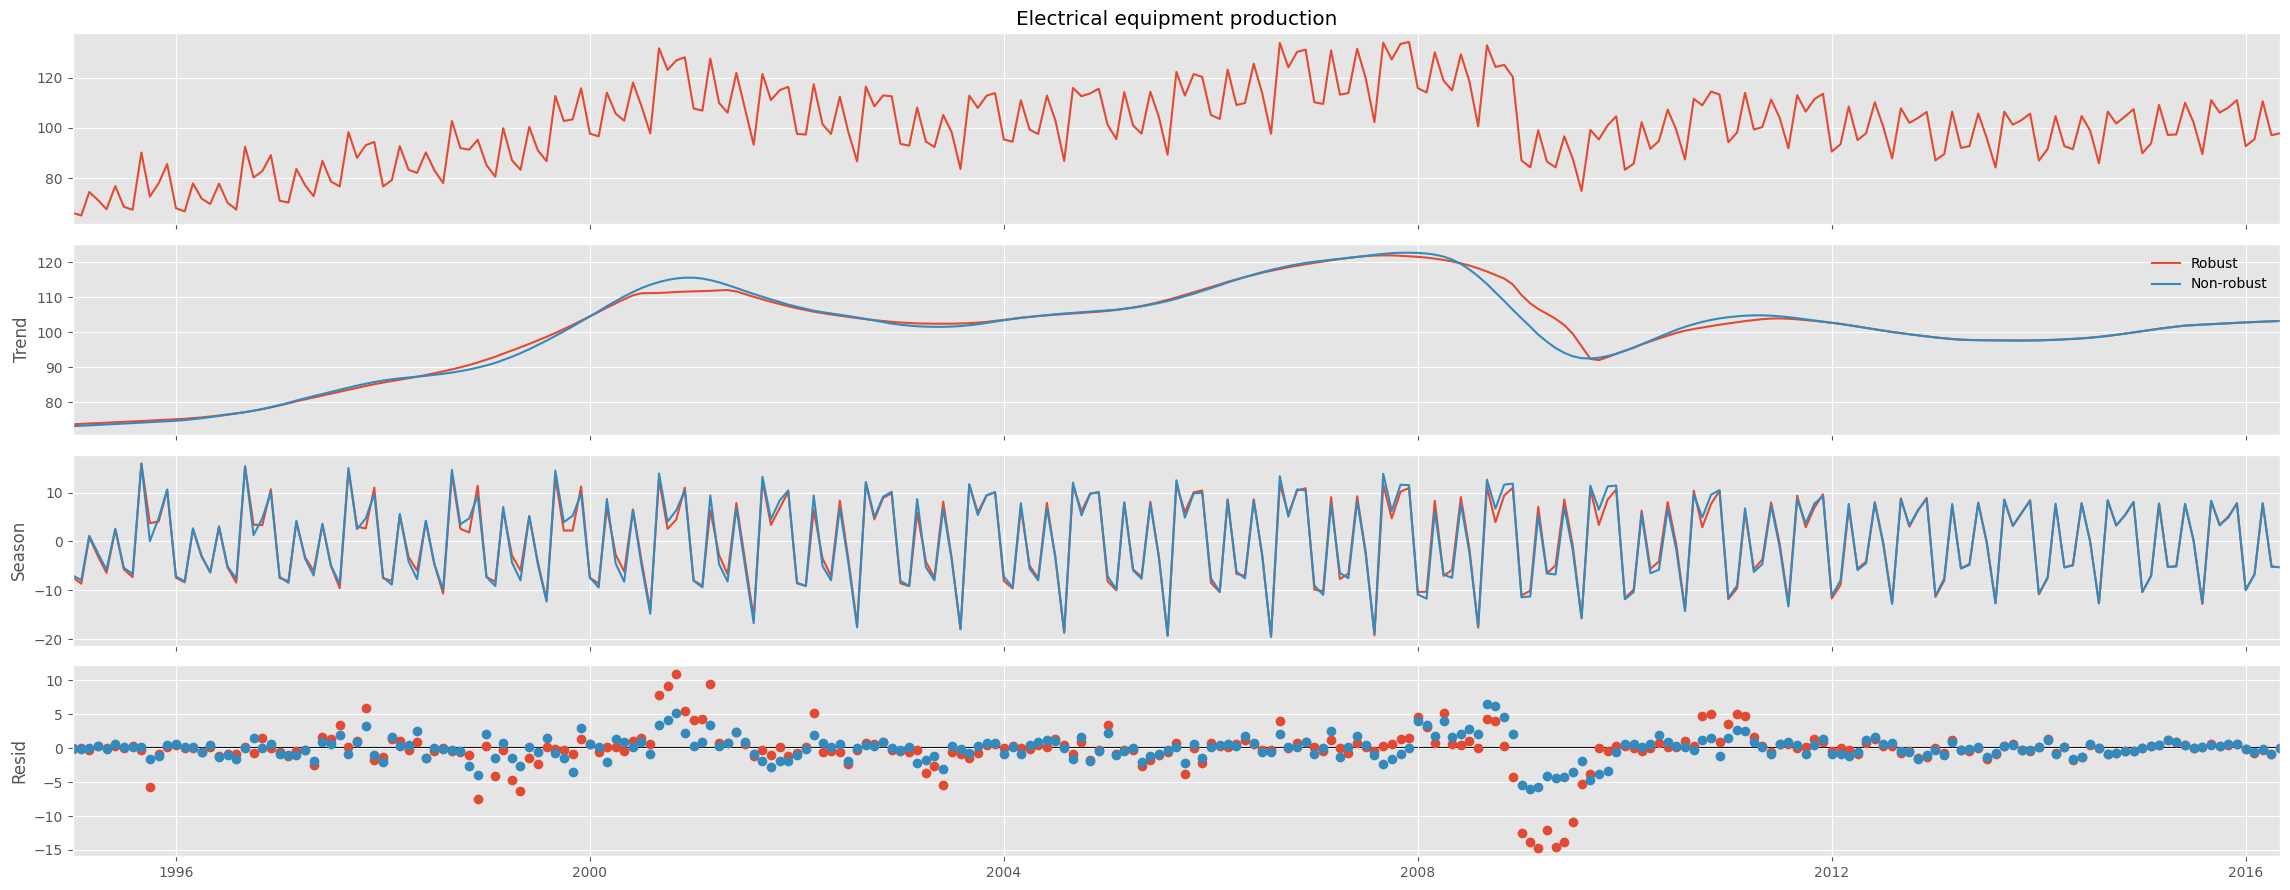

In [104]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(data, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(data, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

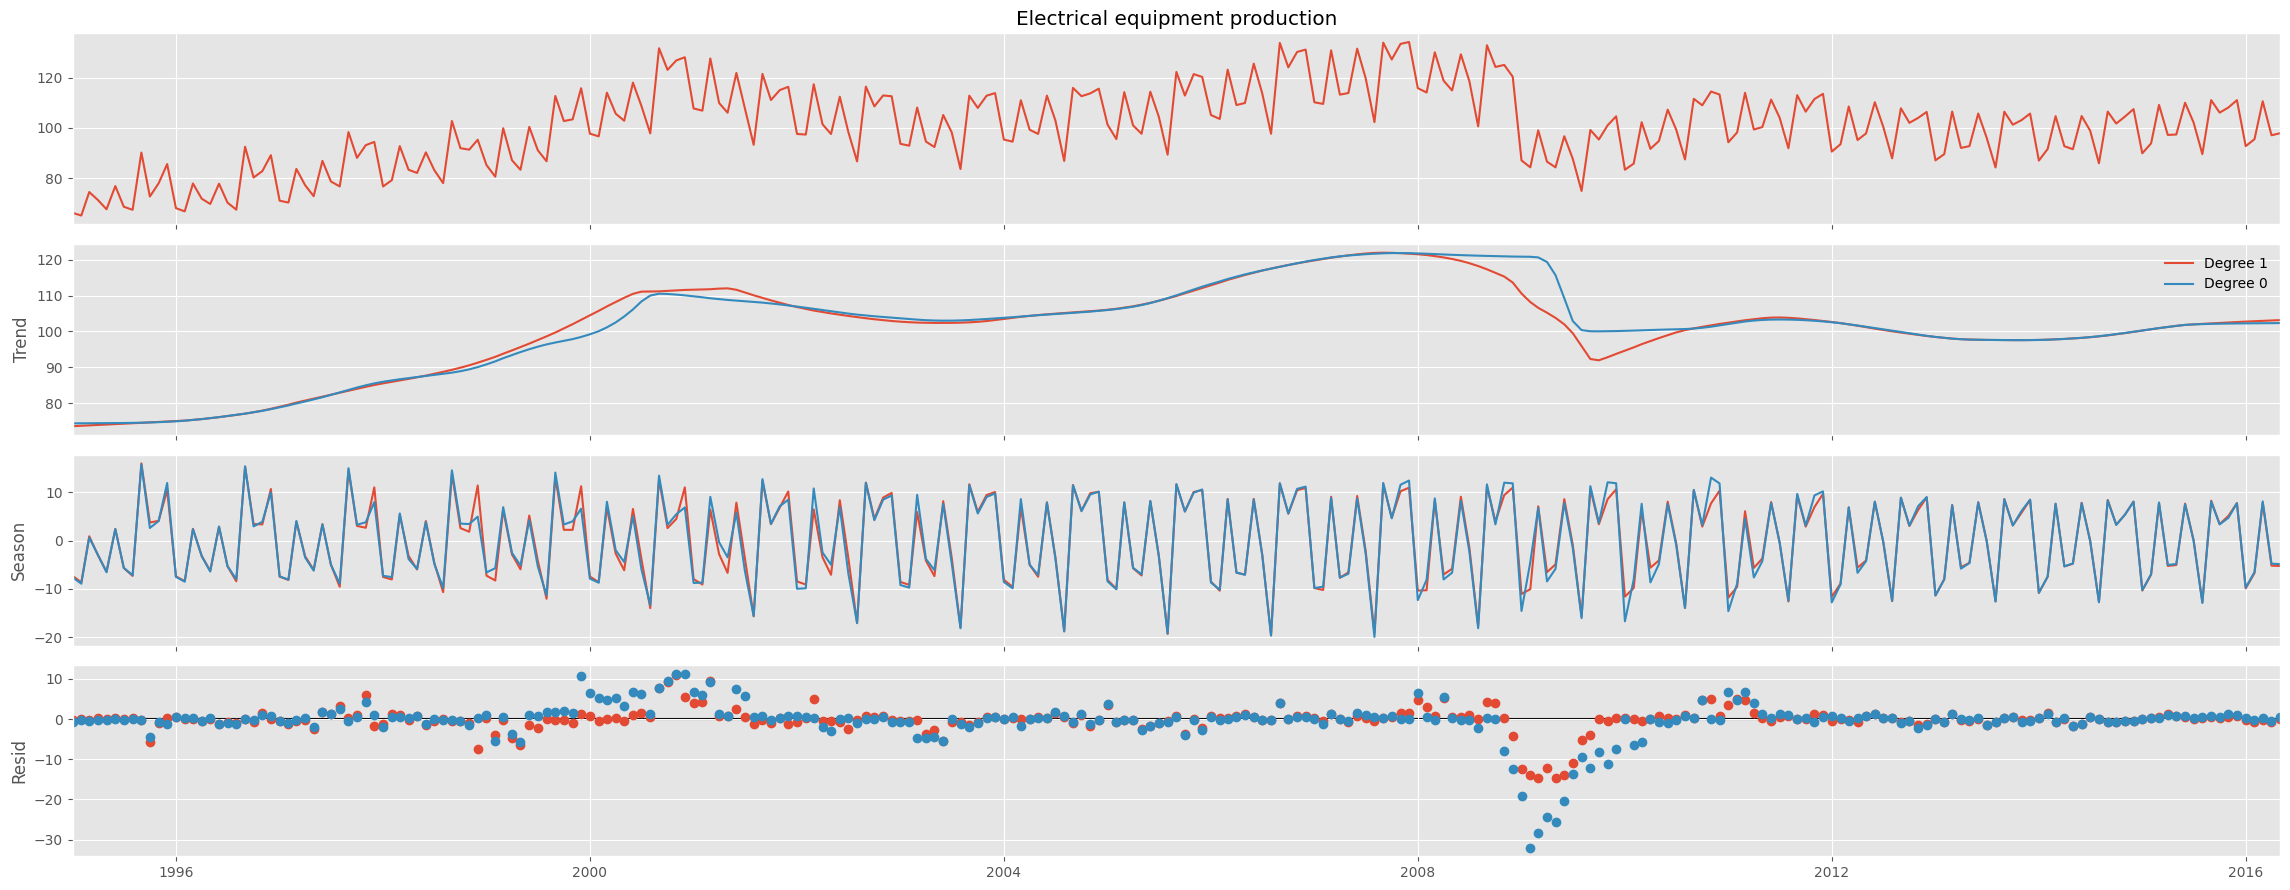

In [90]:
stl = STL(
    data, period=12, seasonal_deg=1, trend_deg=0, low_pass_deg=0, robust=True
)
res_deg_0 = stl.fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])

In [105]:
res_robust.seasonal

DATE
1995-01-01   -7.311339
1995-02-01   -8.649707
1995-03-01    0.876779
1995-04-01   -3.069149
1995-05-01   -6.449497
                ...   
2016-01-01   -9.906274
2016-02-01   -6.729840
2016-03-01    7.814655
2016-04-01   -5.200578
2016-05-01   -5.274804
Name: season, Length: 257, dtype: float64

In [106]:
res_robust.trend

DATE
1995-01-01     73.631208
1995-02-01     73.747981
1995-03-01     73.864713
1995-04-01     73.981555
1995-05-01     74.098765
                 ...    
2016-01-01    102.751118
2016-02-01    102.862322
2016-03-01    102.967364
2016-04-01    103.066429
2016-05-01    103.159972
Name: trend, Length: 257, dtype: float64

In [107]:
dir(res_robust)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_observed',
 '_resid',
 '_seasonal',
 '_trend',
 '_weights',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend',
 'weights']

## MSTL

In [109]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

df.head()

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_84631/3517222309.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))


y
2020-01-01 00:00:00  1.854782
2020-01-01 01:00:00  4.707056
2020-01-01 02:00:00  4.196810
2020-01-01 03:00:00  4.875367
2020-01-01 04:00:00  4.787559

<Axes: >

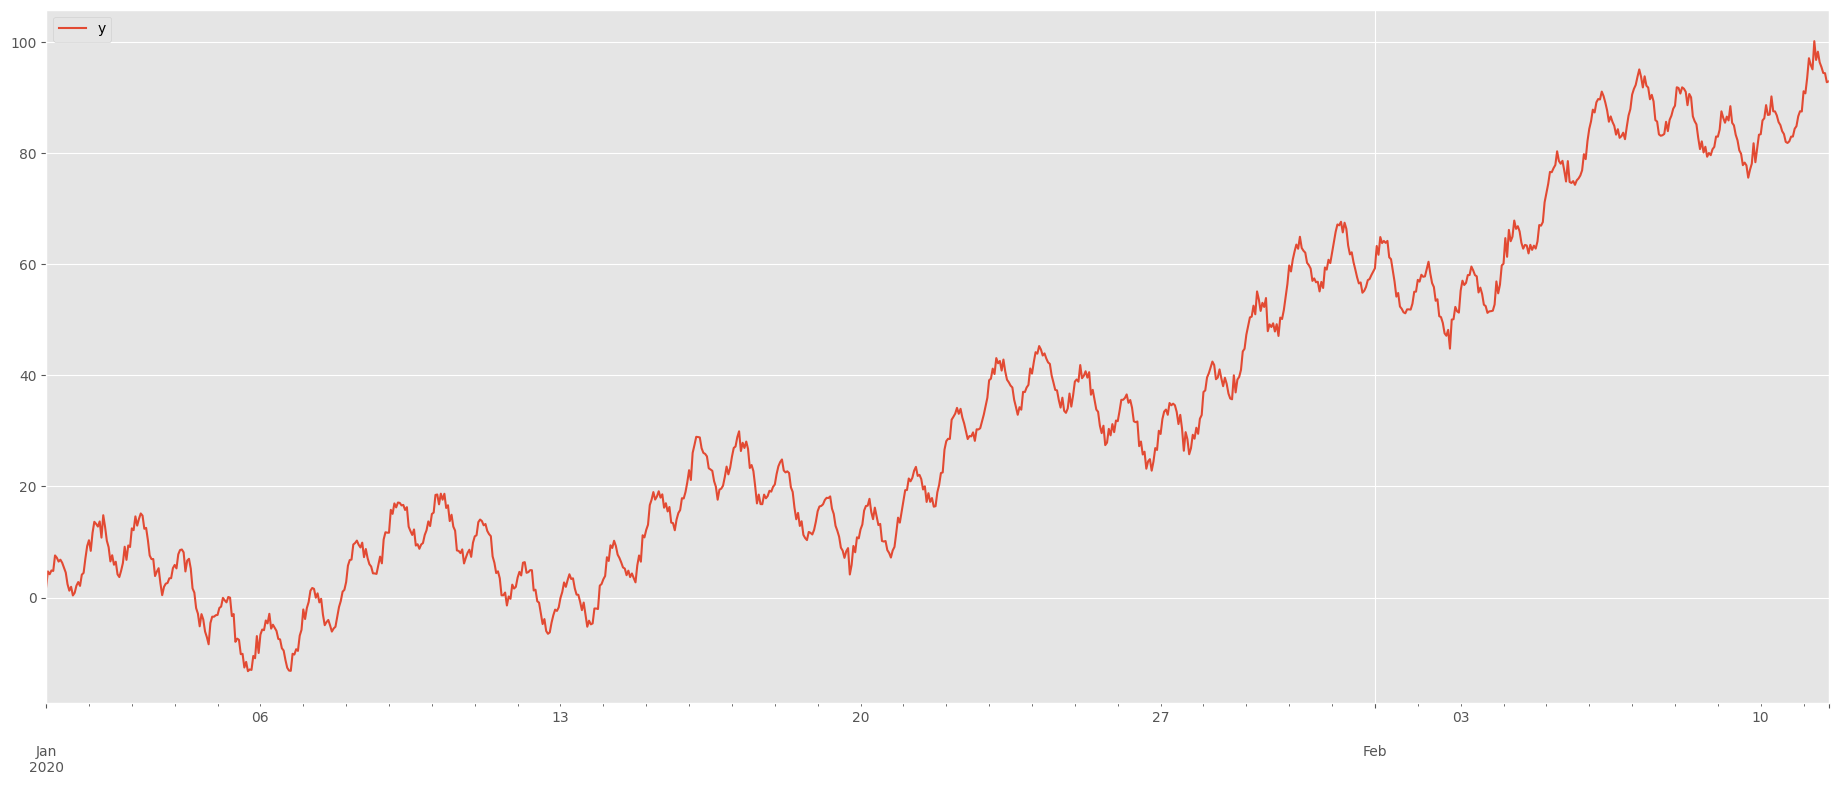

In [110]:
df.plot()

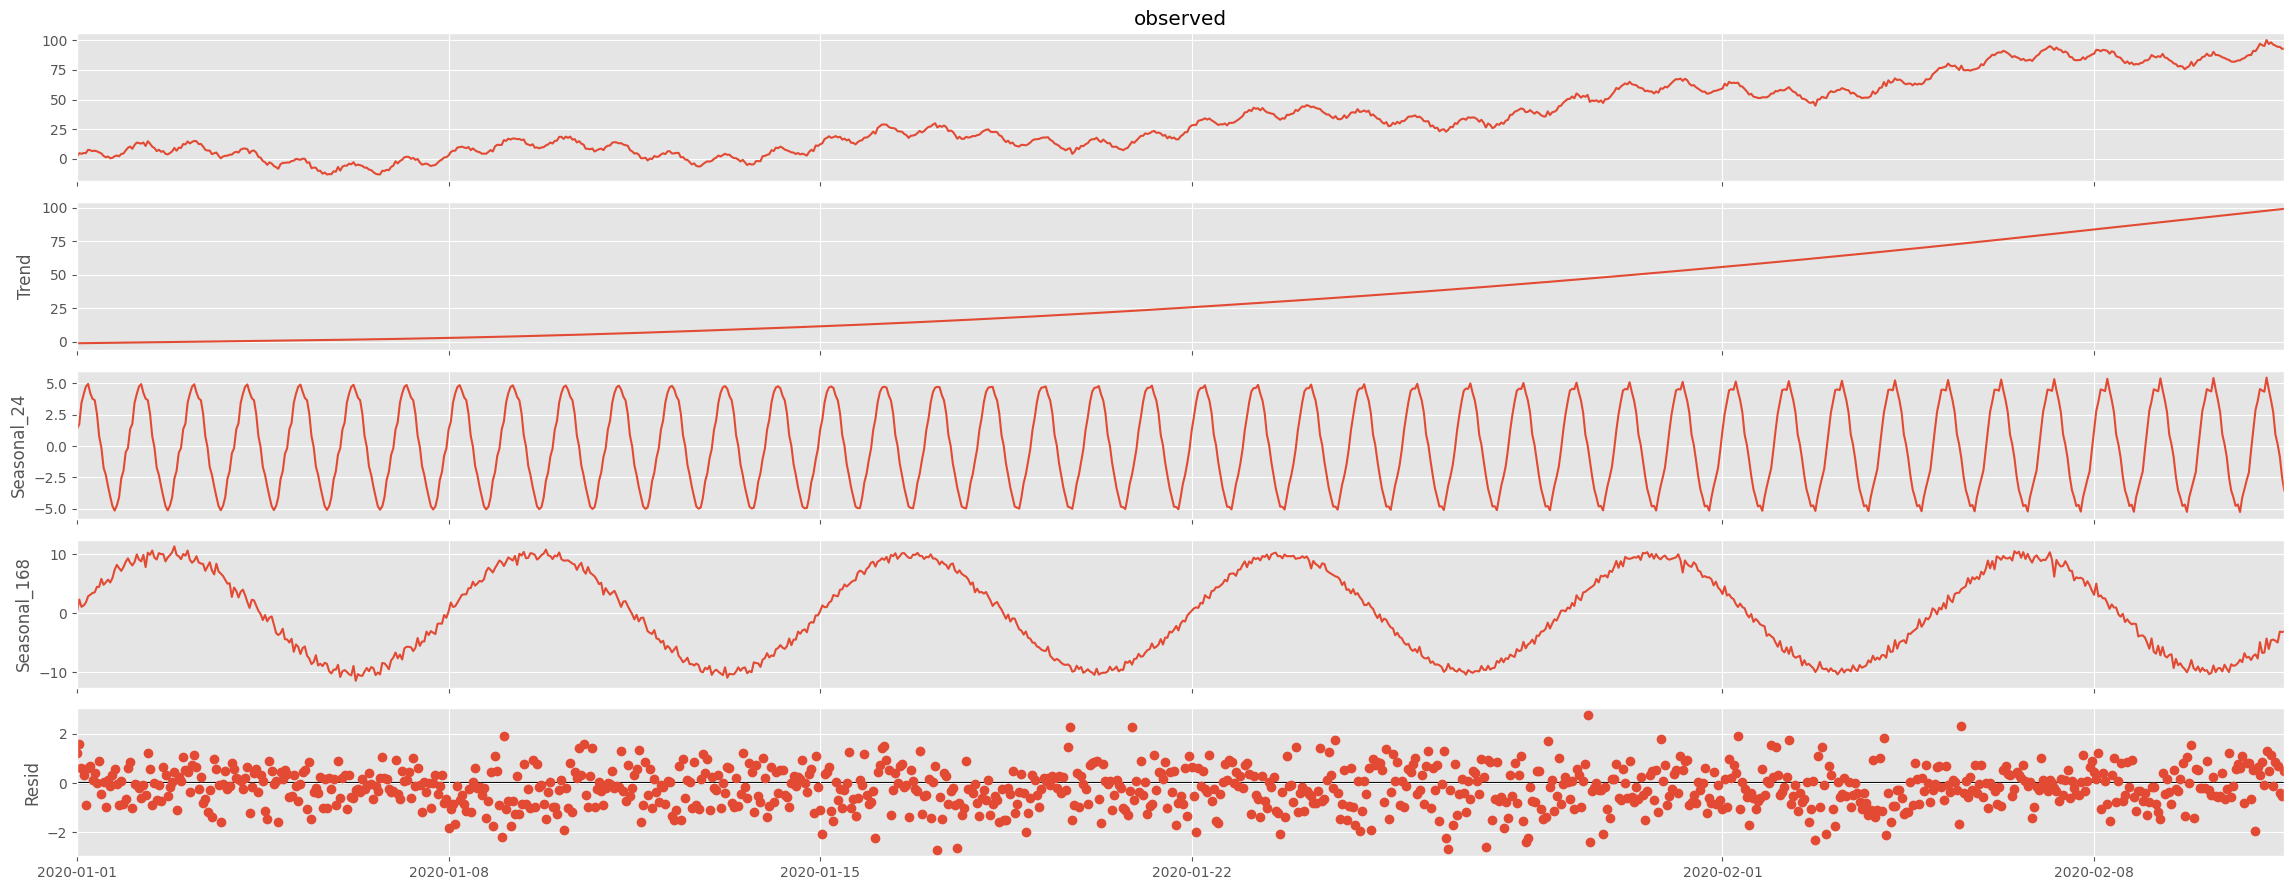

In [116]:
mstl = MSTL(df["y"], periods=[24, 24 * 7], windows=[101, 181])
res = mstl.fit()
res.plot(fig);

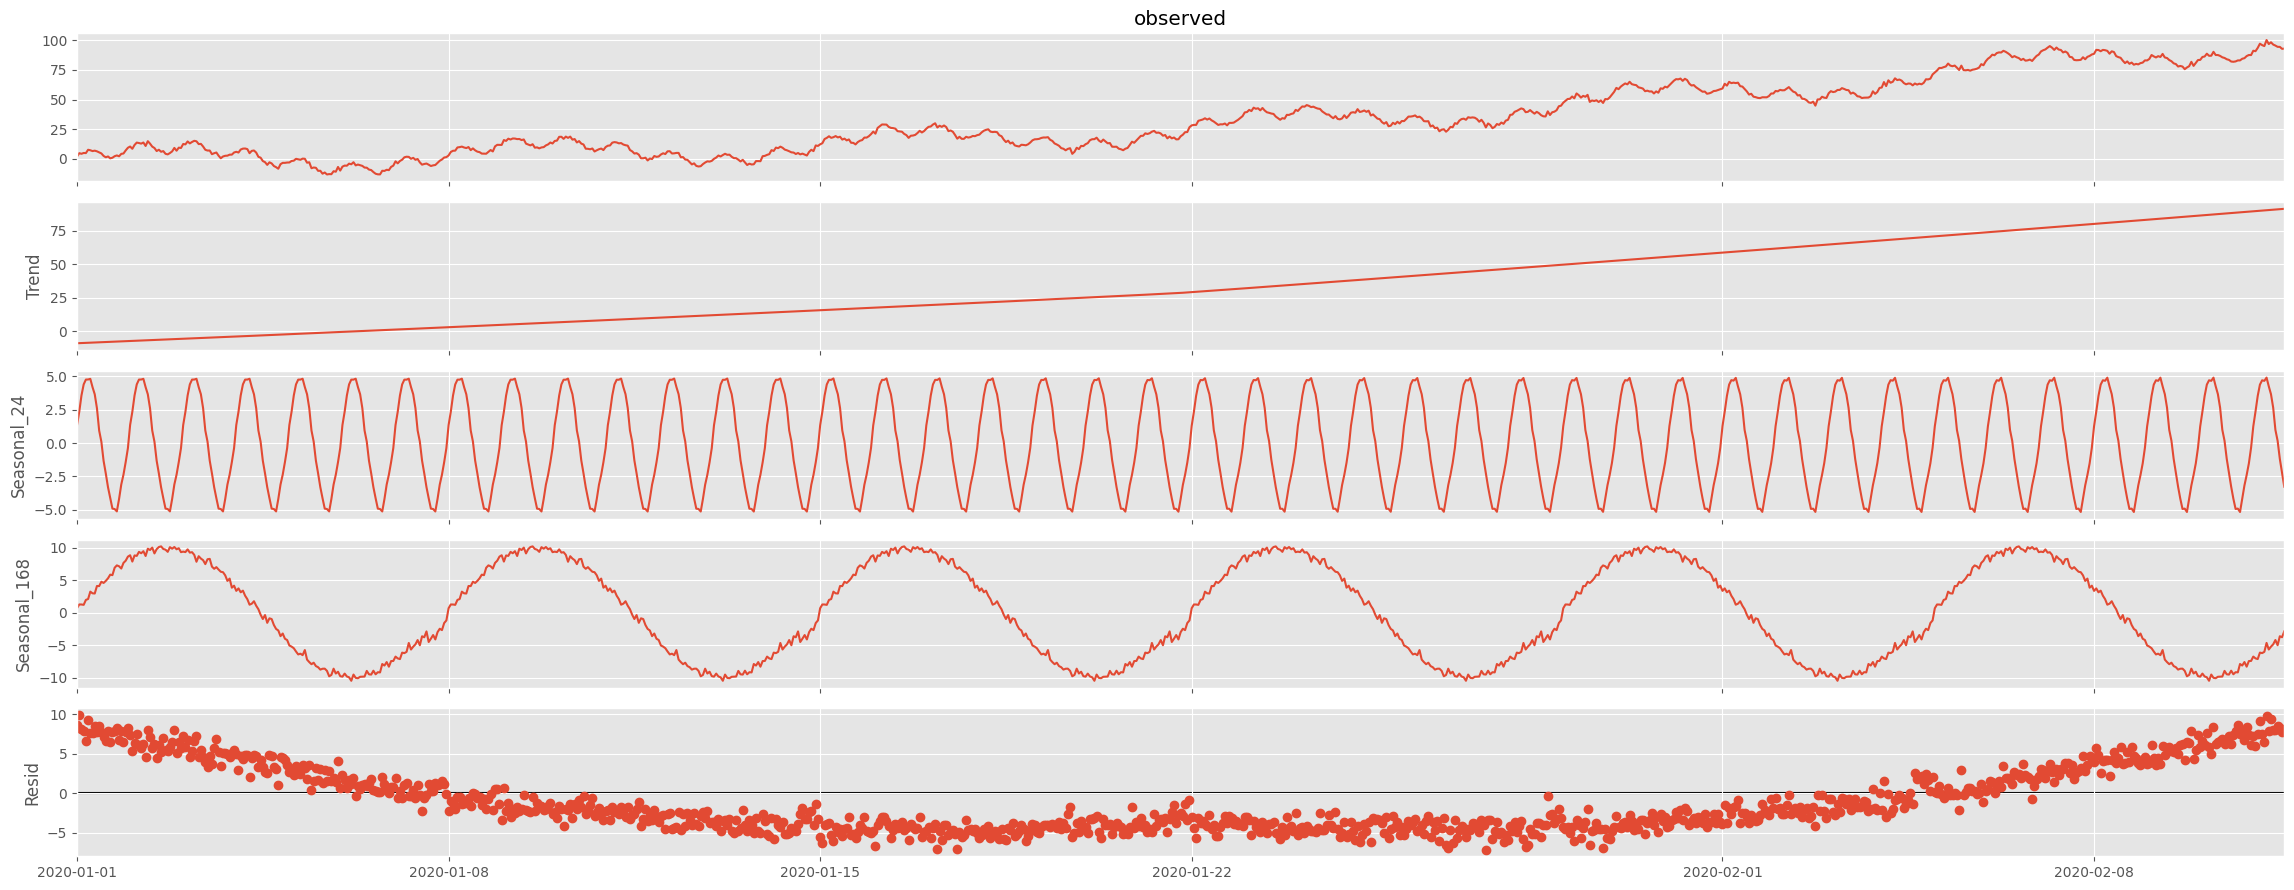

In [117]:
mstl = MSTL(
    df,
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
ax = res.plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='resid'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

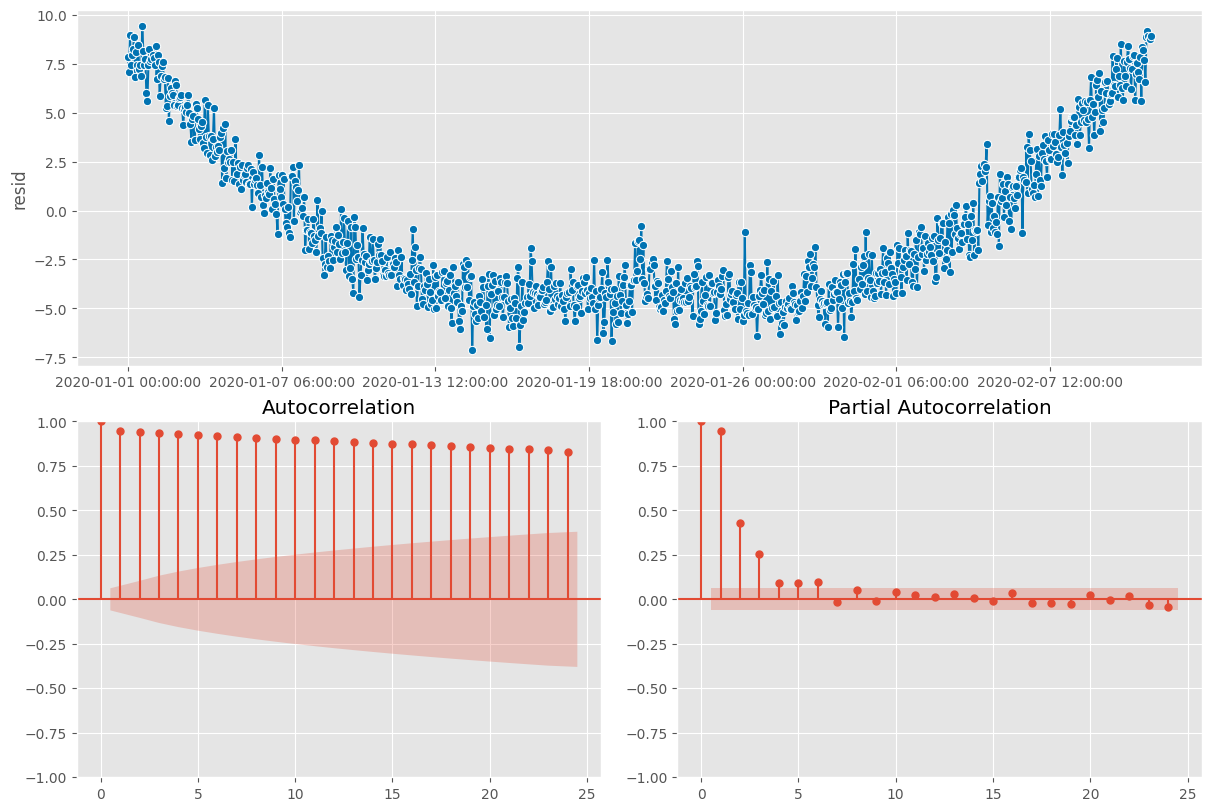

In [15]:
plot_correlations(res.resid)

In [119]:
# Штат Виктория, Мельбурн
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.head()

Date  Period  OperationalLessIndustrial   Industrial
0  37257       1                3535.867064  1086.132936
1  37257       2                3383.499028  1088.500972
2  37257       3                3655.527552  1084.472448
3  37257       4                3510.446636  1085.553364
4  37257       5                3294.697156  1081.302844

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_84631/3109498920.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timeseries = timeseries.set_index("ds").resample("H").sum()


<Axes: xlabel='ds'>

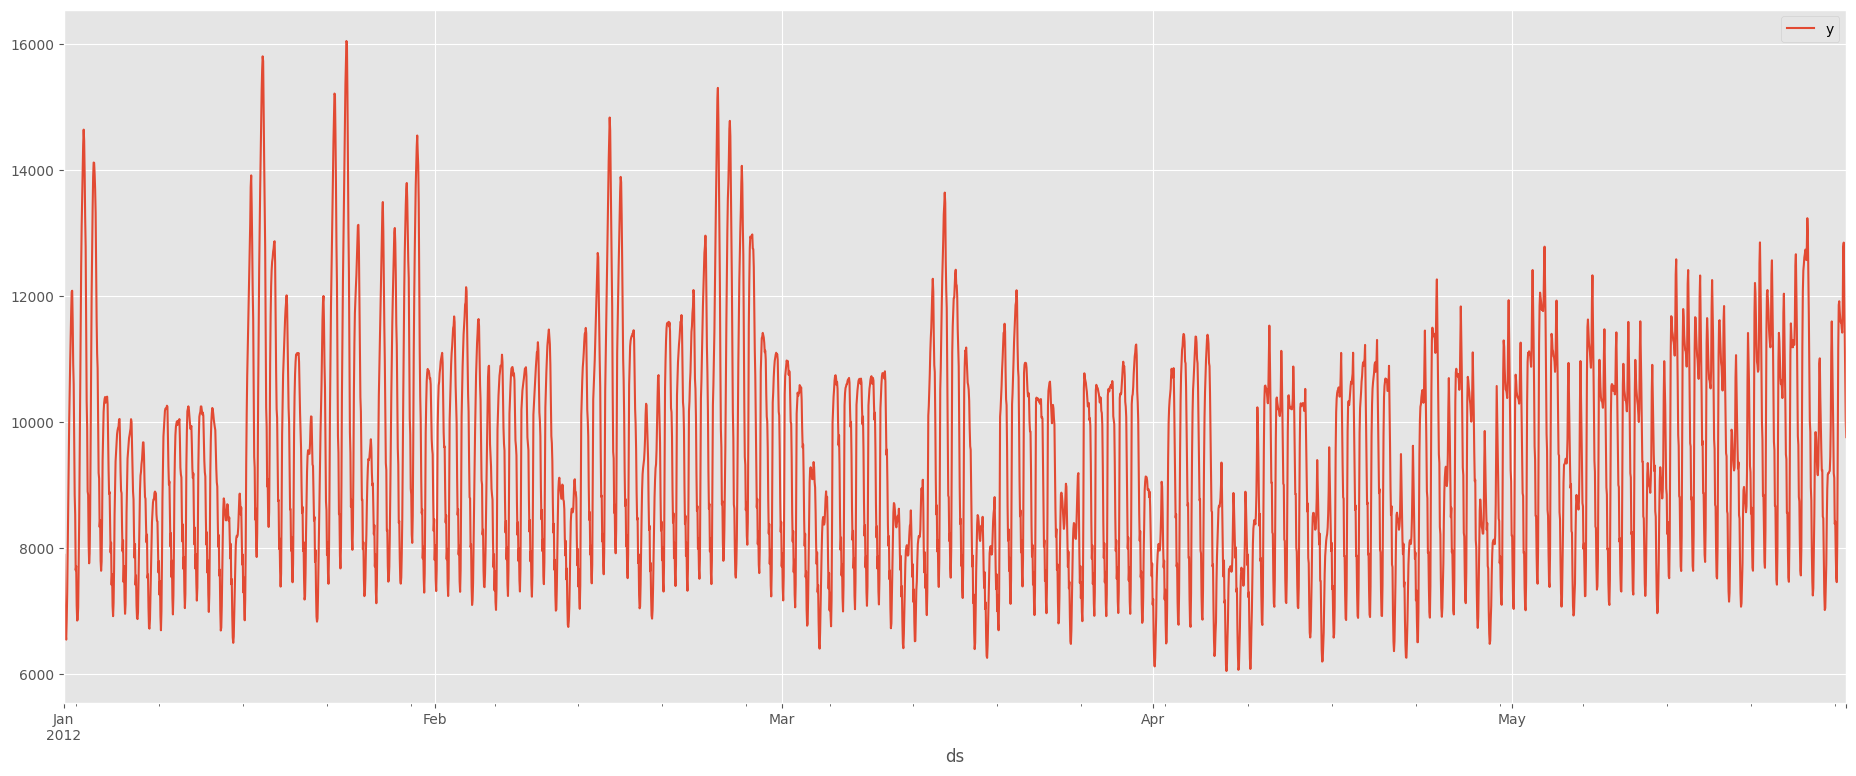

In [120]:


df.head()

df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")

timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.plot()

In [128]:
timeseries

y
ds                               
2012-01-01 00:00:00   7926.529376
2012-01-01 01:00:00   7901.826990
2012-01-01 02:00:00   7255.721350
2012-01-01 03:00:00   6792.503352
2012-01-01 04:00:00   6635.984460
...                           ...
2012-05-28 19:00:00  12176.790792
2012-05-28 20:00:00  11581.352324
2012-05-28 21:00:00  10835.243698
2012-05-28 22:00:00  10024.835748
2012-05-28 23:00:00   9763.270614

[3576 rows x 1 columns]

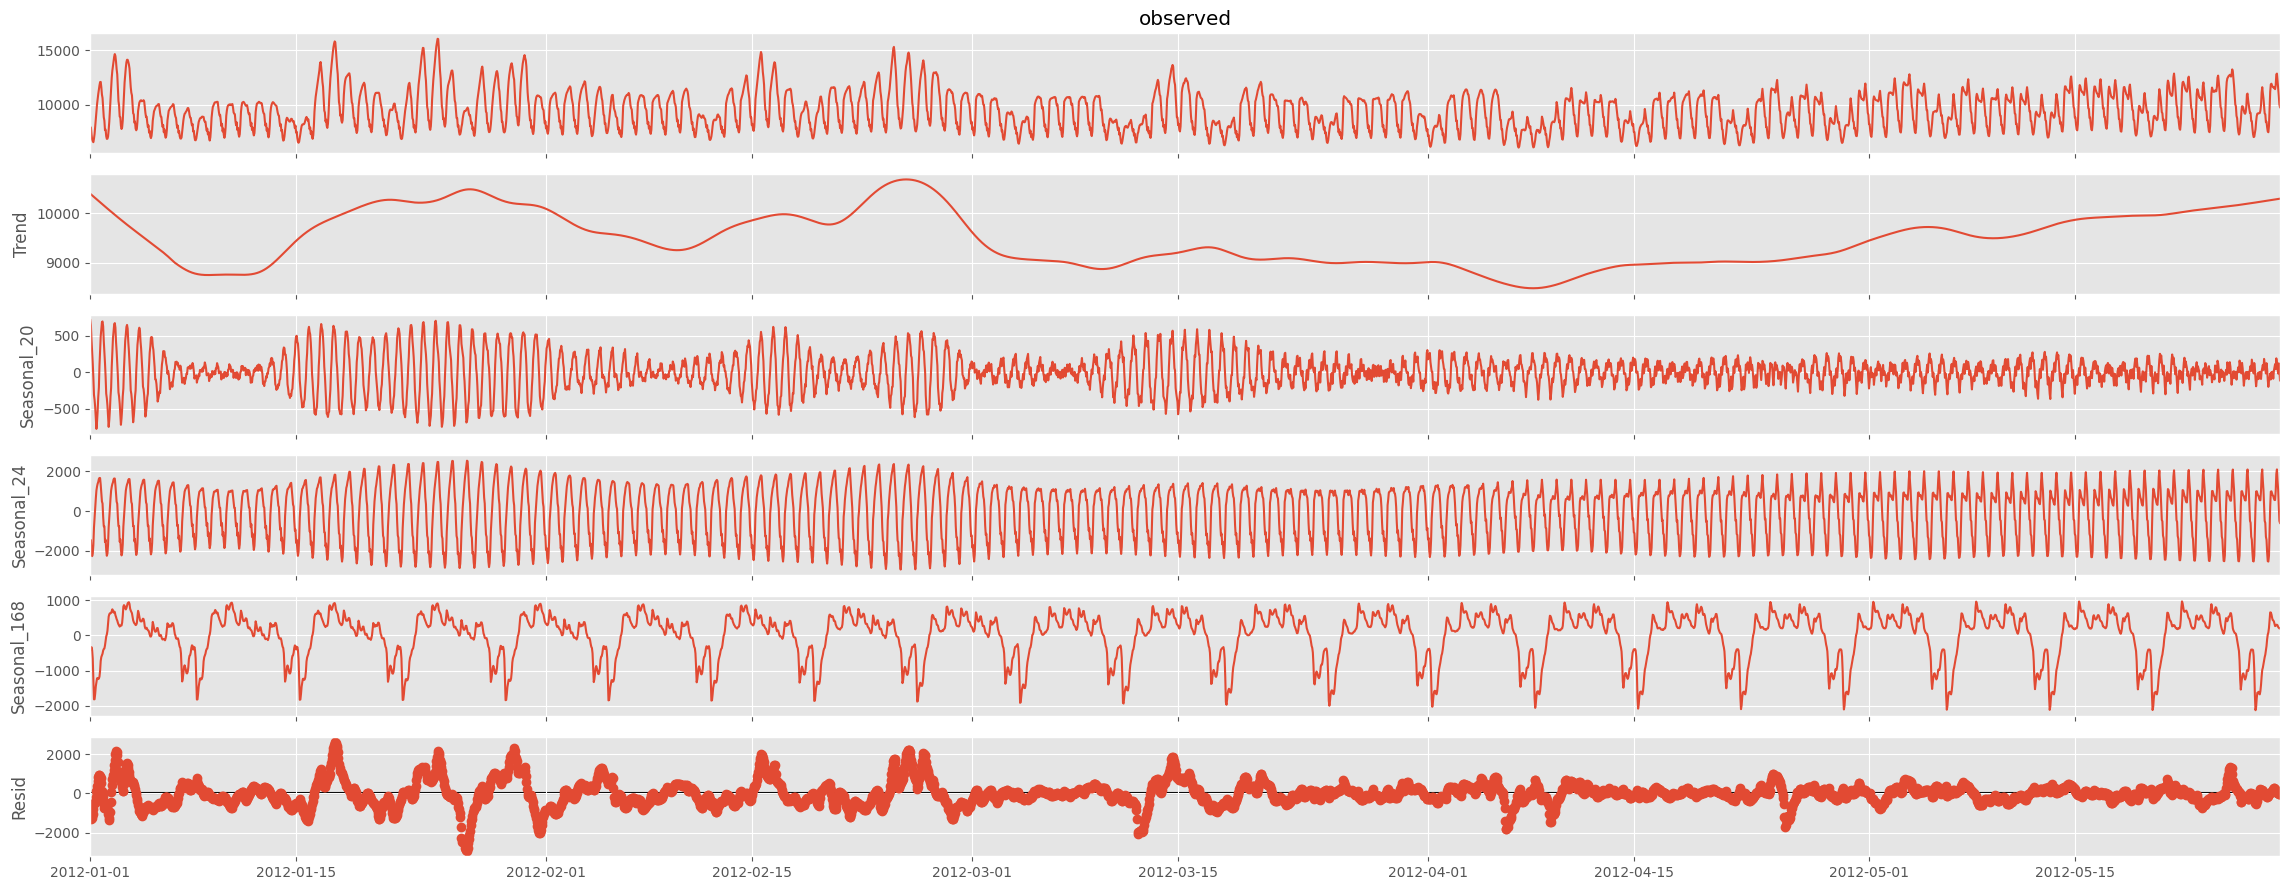

In [135]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7, 20], iterate=3, stl_kwargs={"seasonal_deg": 0, #Эти параметры установлены только для того
                                                                          "inner_iter": 2, #чтобы соответствовать исходной статье
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()

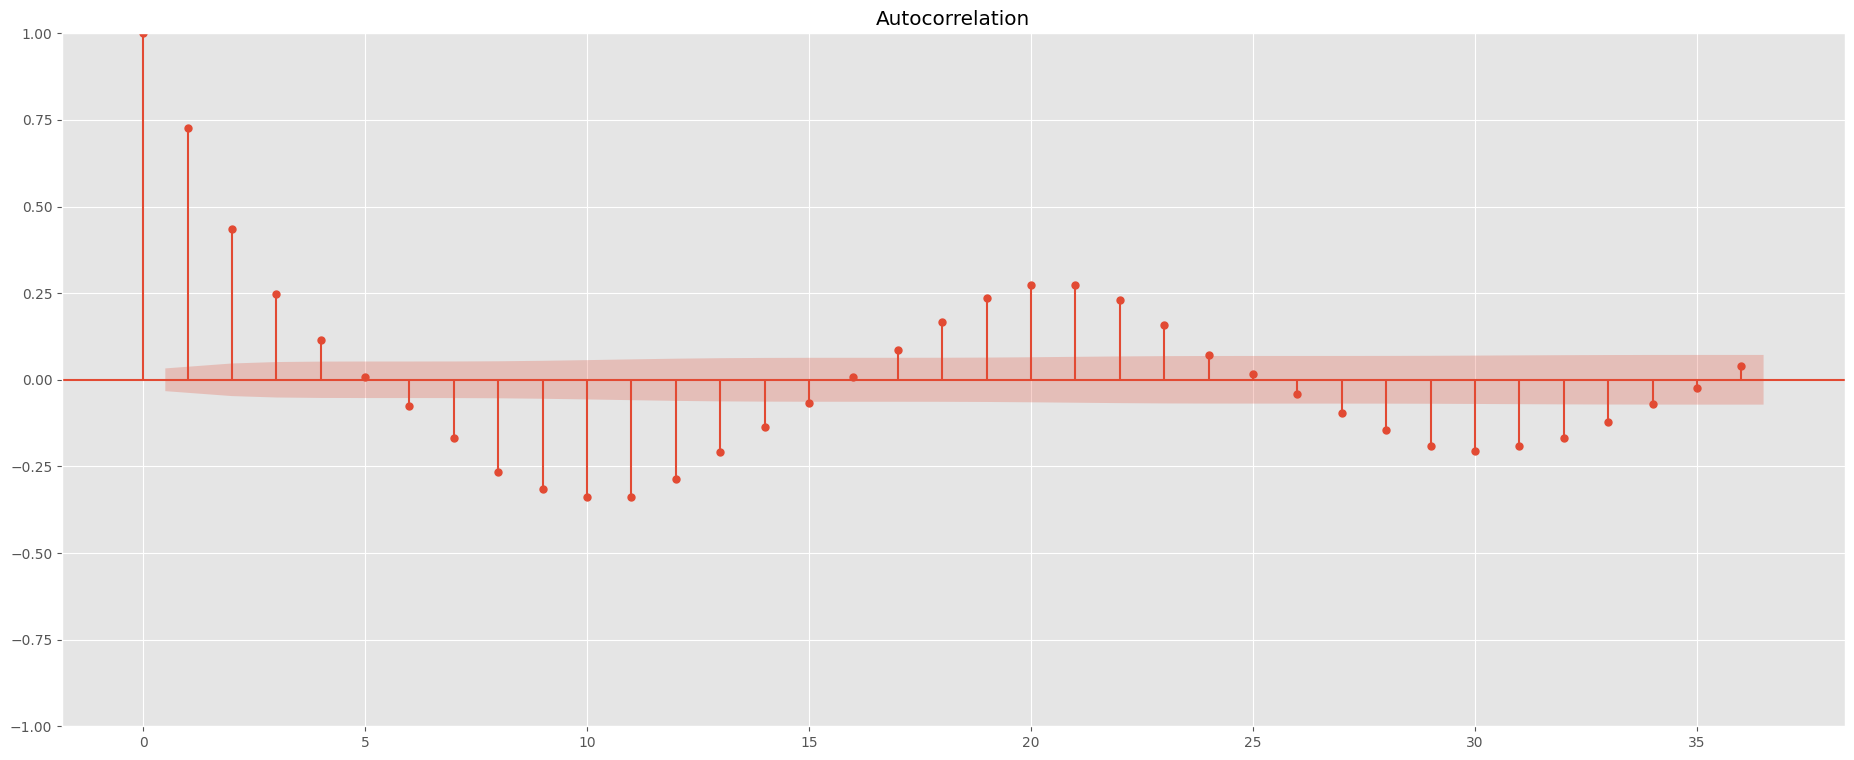

In [133]:
plot_acf(res.resid.diff().dropna());

Дневной паттерн вполне логичный. Днём включаем кондиционер. На недельном паттерне по выходным потребление ниже.

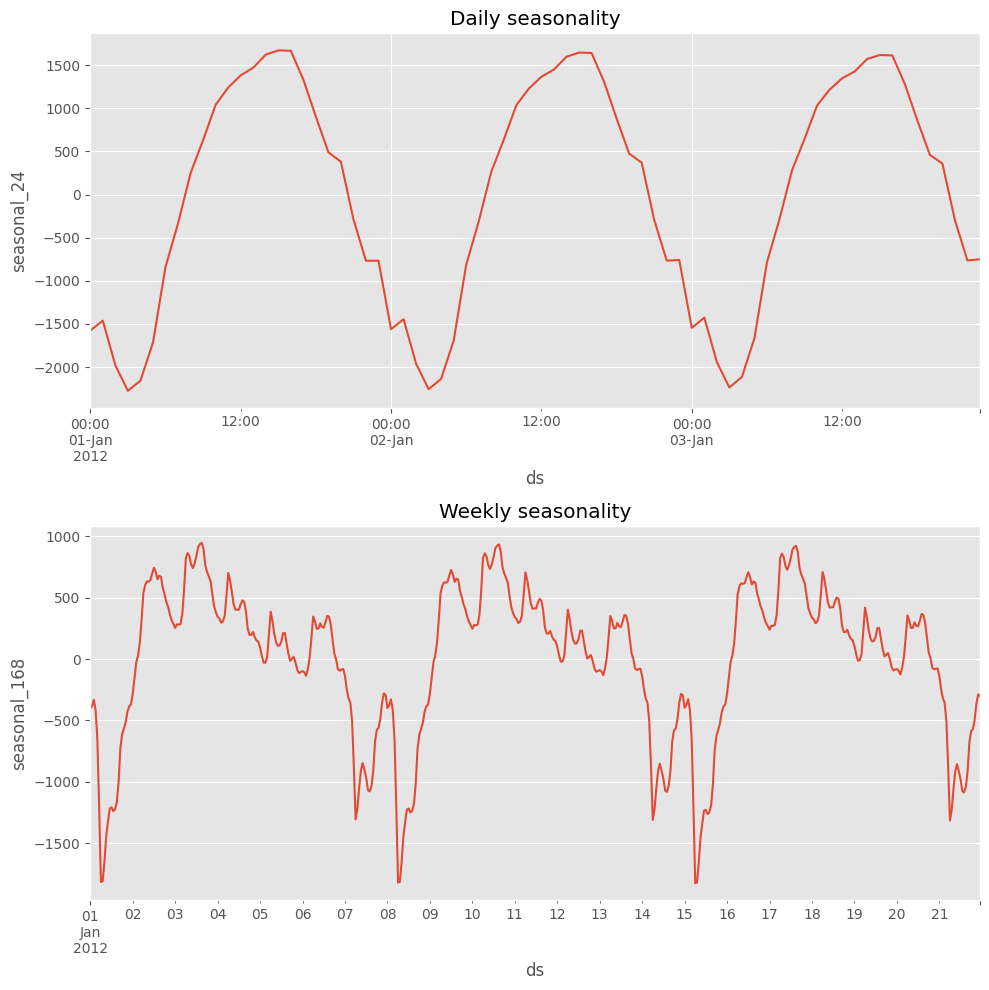

In [136]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

А теперь видим, что дневной паттерн поменялся. Не забываем, что в южном полушарии сезоны наоборот. Вечером теперь необходимо всключать отопление и свет. На выходных потребление также понижается.

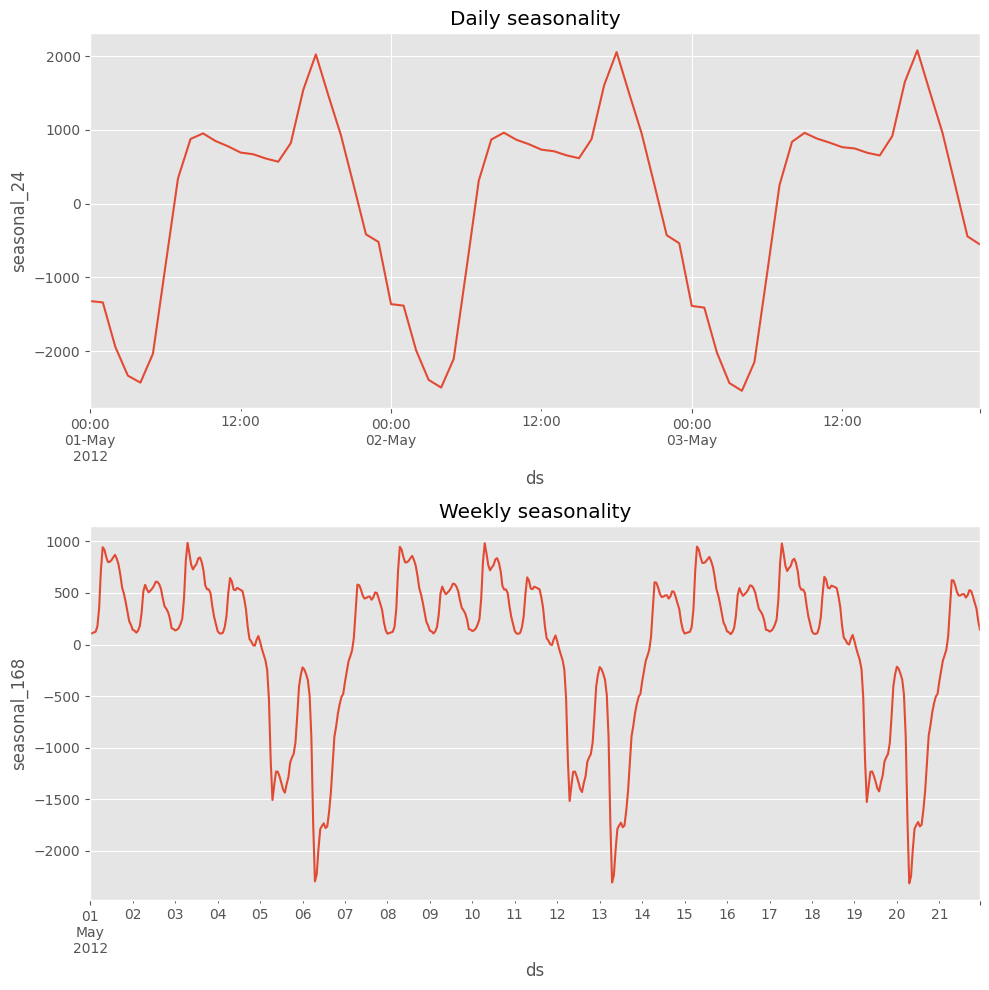

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
mask = res.seasonal.index.month==5
res.seasonal[mask]["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

## Обработка пропусков

Обработка пропусков во временных рядах связана всё с той же проблемой: данные связаны по времени. Это с одной стороны помогает, а с другой стороны мешает. Разберём некоторые наиболее значимые кейсы.

#### Смотрим на контекст!

Часто само происхождение данных или непосредственно задача диктует правила обработки пропусков. Рассмотрим пример ниже. Вам представлен график недельных цен на некоторый вид химического сырья в некотором регионе мира. В данном случае вполне логично интерпретировать пропуски как "цена не изменилась", поэтому можно заполнить пропуски просто последним доступным значением. С одной стороны это, конечно, снижает дисперсию данных, но при этом он обоснован.

In [25]:
flat = pd.read_csv('data/sem_2/weekly_flat.csv', index_col=0)
flat.index = pd.to_datetime(flat.index)

In [137]:

plt.plot(flat)
plt.title('Исходный ряд');

NameError: name 'flat' is not defined

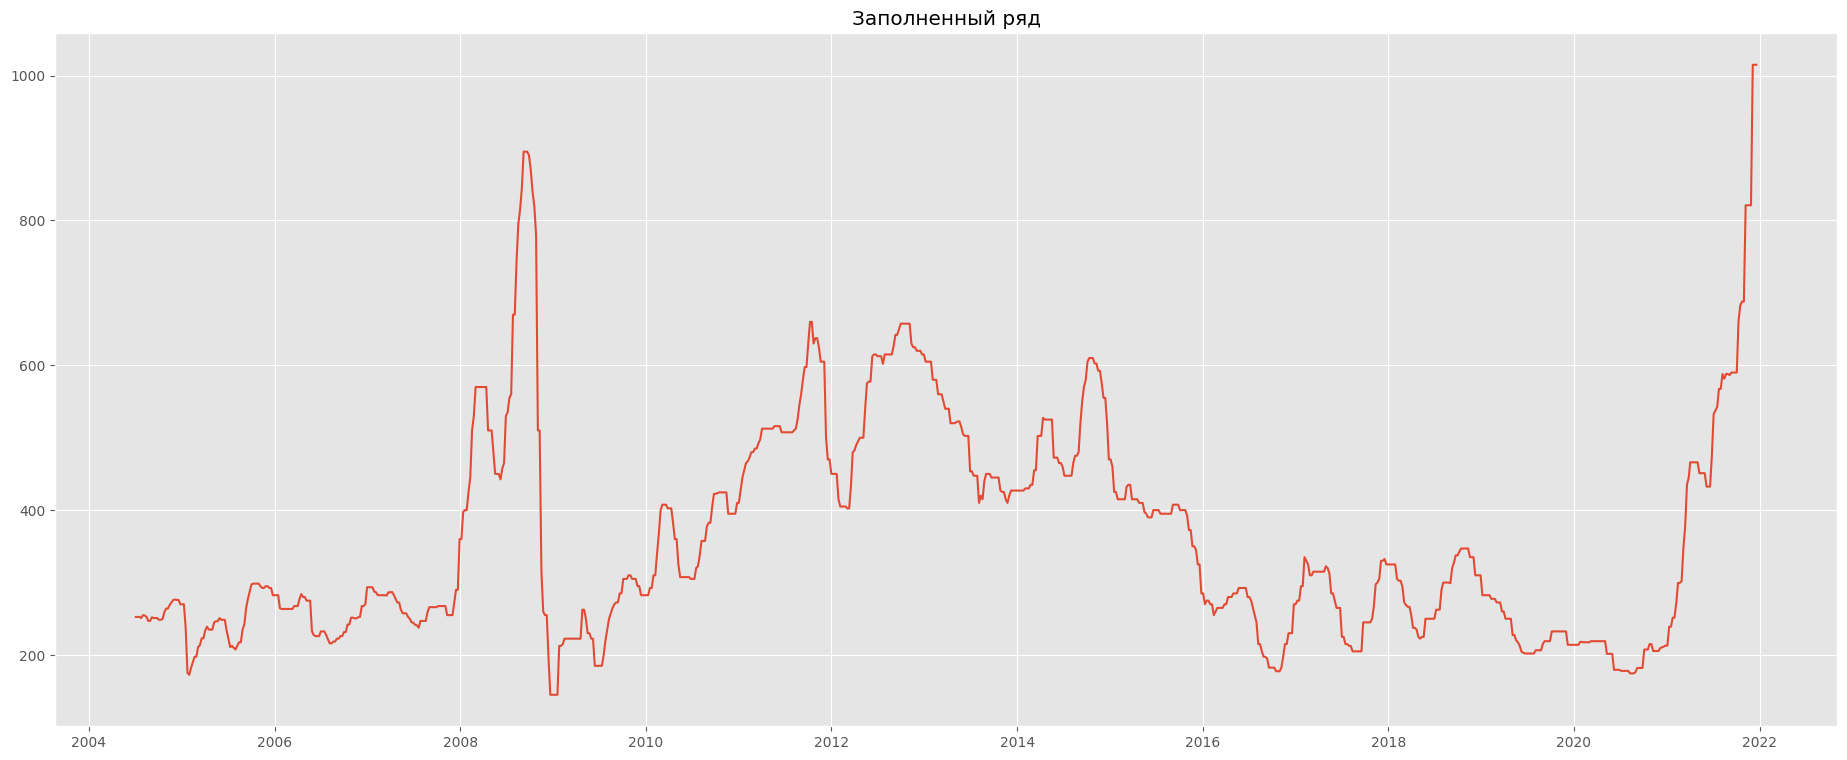

In [27]:

plt.plot(flat.ffill())
plt.title('Заполненный ряд');

#### Смотрим на структуру данных!

Любые паттерны данных и их структура могут помочь в заполнении пропусков. Во-первых, если в данных есть тренд.

In [138]:
macro = sm.datasets.macrodata.load_pandas().data

#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
macro.index = pd.date_range(start = '01.01.1959', periods = len(macro), freq='Q')
display(macro)
macro = macro.drop(columns = ['year', 'quarter'])

mask = np.random.binomial(1, 0.2, size=len(macro)) > 0 
gdp_true = macro.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_84631/4239953747.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  macro.index = pd.date_range(start = '01.01.1959', periods = len(macro), freq='Q')


year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
1959-03-31  1959.0      1.0   2710.349    1707.4   286.898   470.045   1886.9   
1959-06-30  1959.0      2.0   2778.801    1733.7   310.859   481.301   1919.7   
1959-09-30  1959.0      3.0   2775.488    1751.8   289.226   491.260   1916.4   
1959-12-31  1959.0      4.0   2785.204    1753.7   299.356   484.052   1931.3   
1960-03-31  1960.0      1.0   2847.699    1770.5   331.722   462.199   1955.5   
...            ...      ...        ...       ...       ...       ...      ...   
2008-09-30  2008.0      3.0  13324.600    9267.7  1990.693   991.551   9838.3   
2008-12-31  2008.0      4.0  13141.920    9195.3  1857.661  1007.273   9920.4   
2009-03-31  2009.0      1.0  12925.410    9209.2  1558.494   996.287   9926.4   
2009-06-30  2009.0      2.0  12901.504    9189.0  1456.678  1023.528  10077.5   
2009-09-30  2009.0      3.0  12990.341    9256.0  1486.398  1044.088  10040.6   

                cpi      m1  tbilrate  unemp      pop  infl  realint  
1959-03-31   28.980   139.7      2.82    5.8  177.146  0.00     0.00  
1959-06-30   29.150   141.7      3.08    5.1  177.830  2.34     0.74  
1959-09-30   29.350   140.5      3.82    5.3  178.657  2.74     1.09  
1959-12-31   29.370   140.0      4.33    5.6  179.386  0.27     4.06  
1960-03-31   29.540   139.6      3.50    5.2  180.007  2.31     1.19  
...             ...     ...       ...    ...      ...   ...      ...  
2008-09-30  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33  
2008-12-31  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91  
2009-03-31  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71  
2009-06-30  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19  
2009-09-30  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44  

[203 rows x 14 columns]

<Axes: >

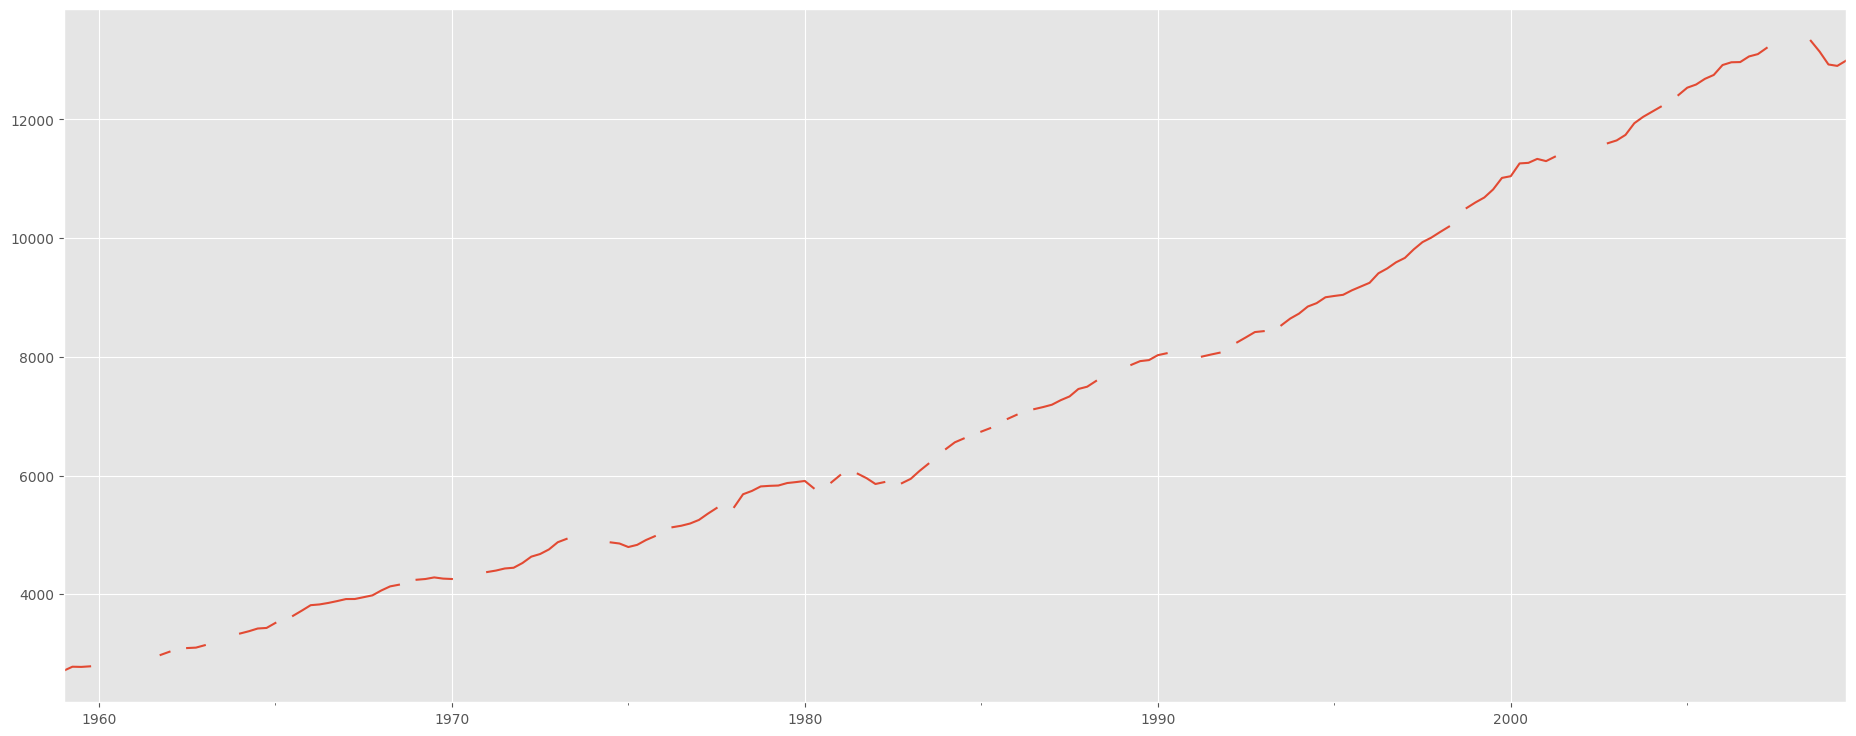

In [139]:
gdp_nan.plot()

<Axes: >

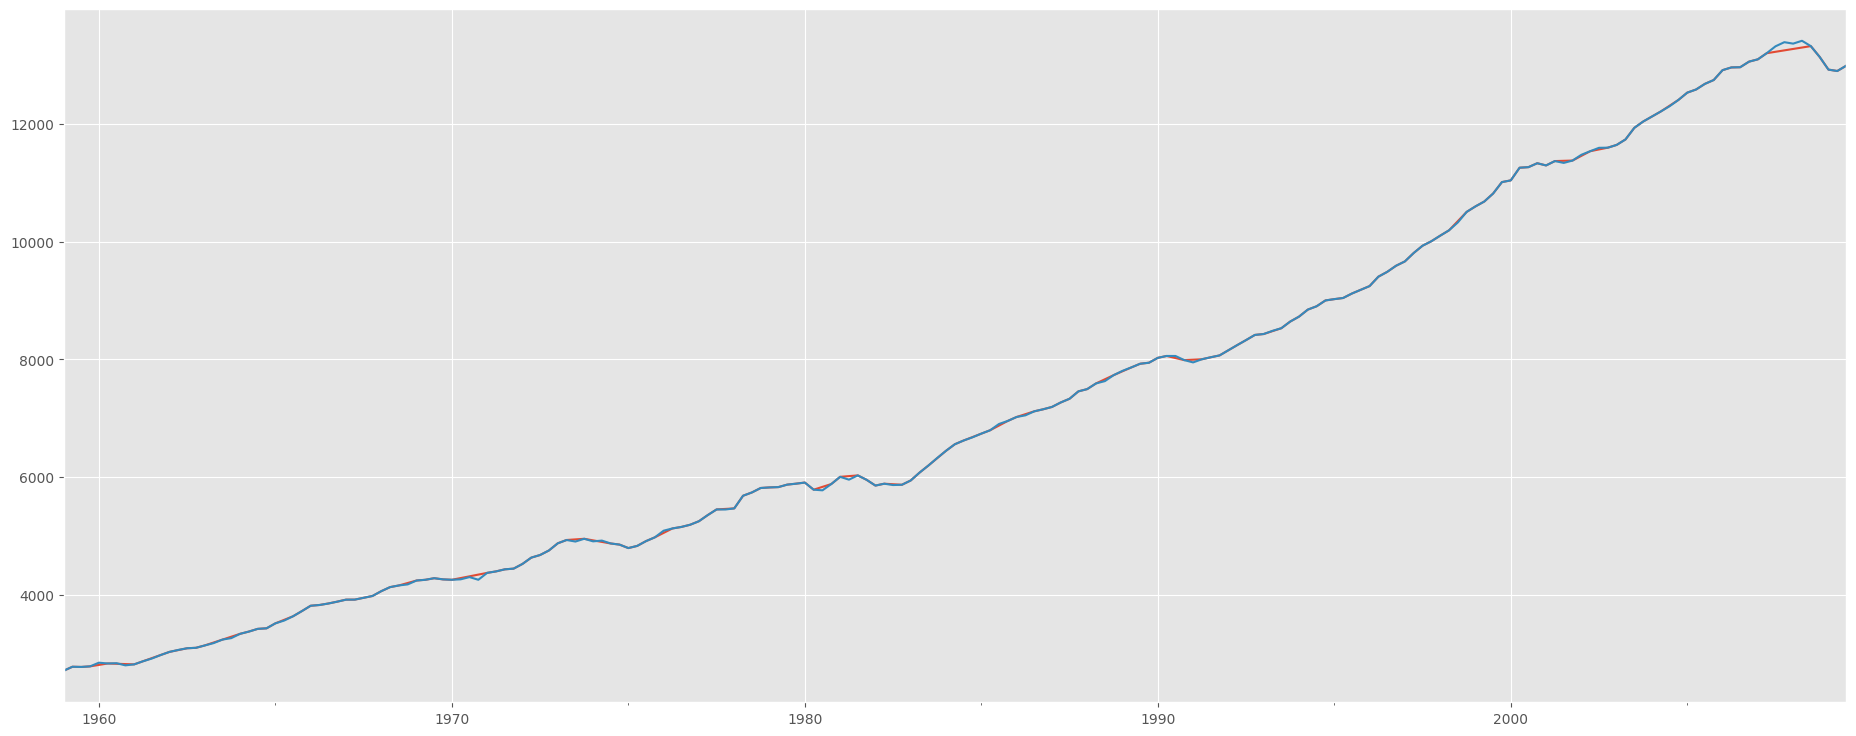

In [140]:
gdp_nan.interpolate(method='linear').plot()
gdp_true.plot()

<Axes: >

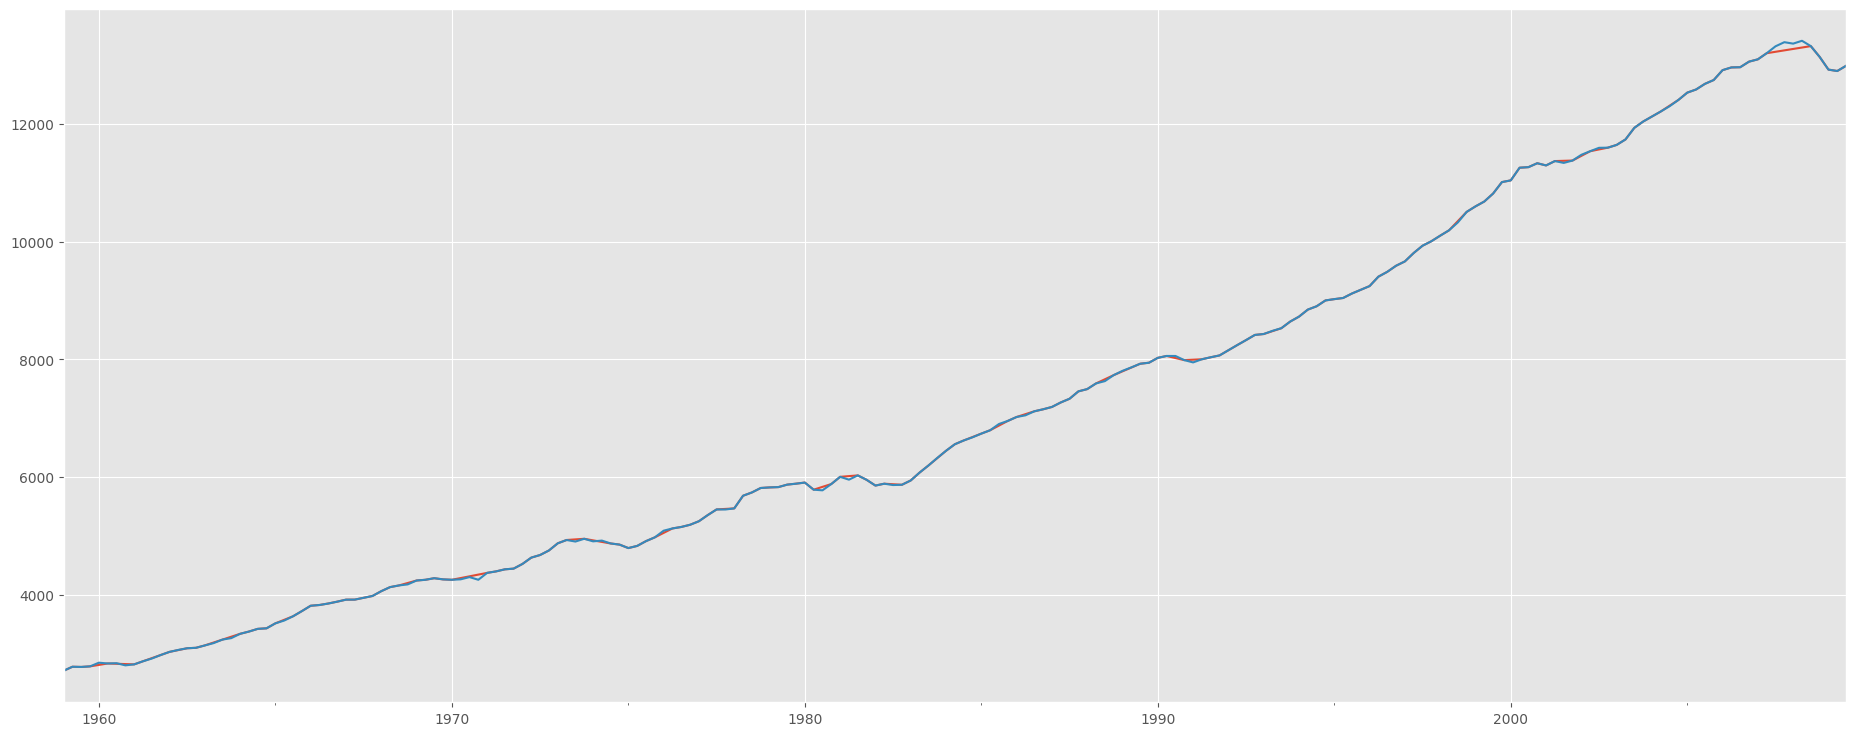

In [141]:
gdp_nan.interpolate(method='time').plot()
gdp_true.plot()

In [142]:
mape(gdp_true[mask], gdp_nan.interpolate(method='time')[mask])

NameError: name 'mape' is not defined

## LOWESS

In [143]:


# mask = np.random.binomial(1, 0.1, size=len(data)) > 0 
gdp_true = macro.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

gdp_nan = gdp_nan.reset_index(drop=True)

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_84631/259556965.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


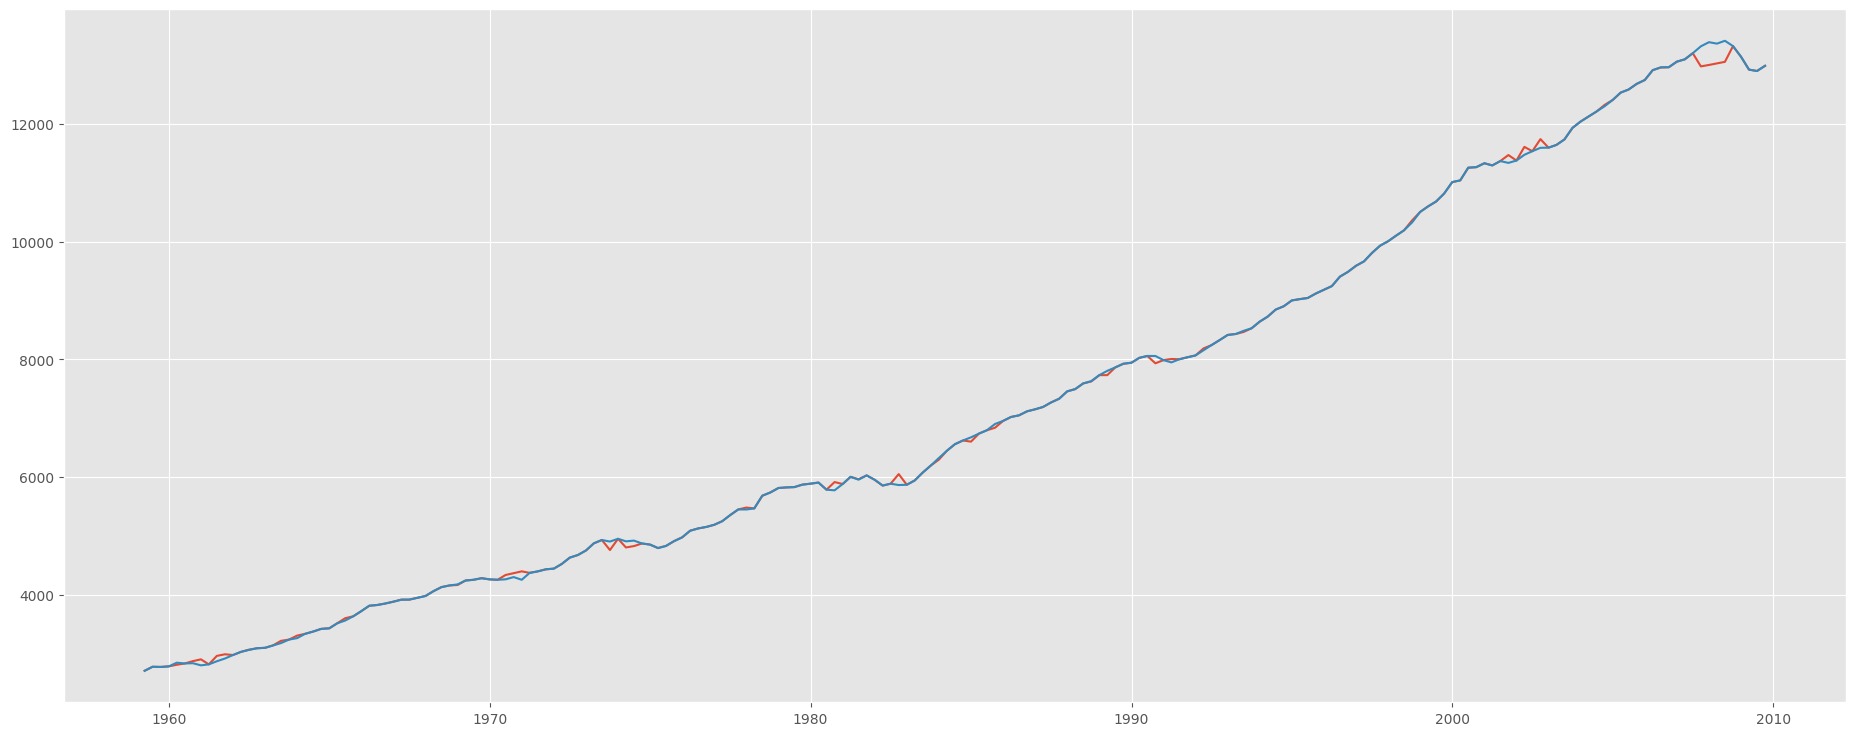

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from moepy import lowess

# Data generation
x = np.array(gdp_nan[~mask].index)
y = gdp_nan[~mask].values

x_pred = np.array(gdp_nan[mask].index)

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.15)

# Model prediction
y_pred = lowess_model.predict(x_pred)
gdp_filled = gdp_nan.copy()
gdp_filled[mask] = y_pred
gdp_filled.index = gdp_true.index

# Plotting
plt.plot(gdp_filled)
plt.plot(gdp_true)
plt.legend(frameon=False)

In [38]:
# MAE заполнения

mape(gdp_true[mask], gdp_filled[mask])

0.013704554322769647

В случае, если данные носят сезонный характер, это тоже можно использовать. Например, заполнять последним доступным значением в аналогичном сезоне или усреднять по двум соседним аналогичным сезонам.

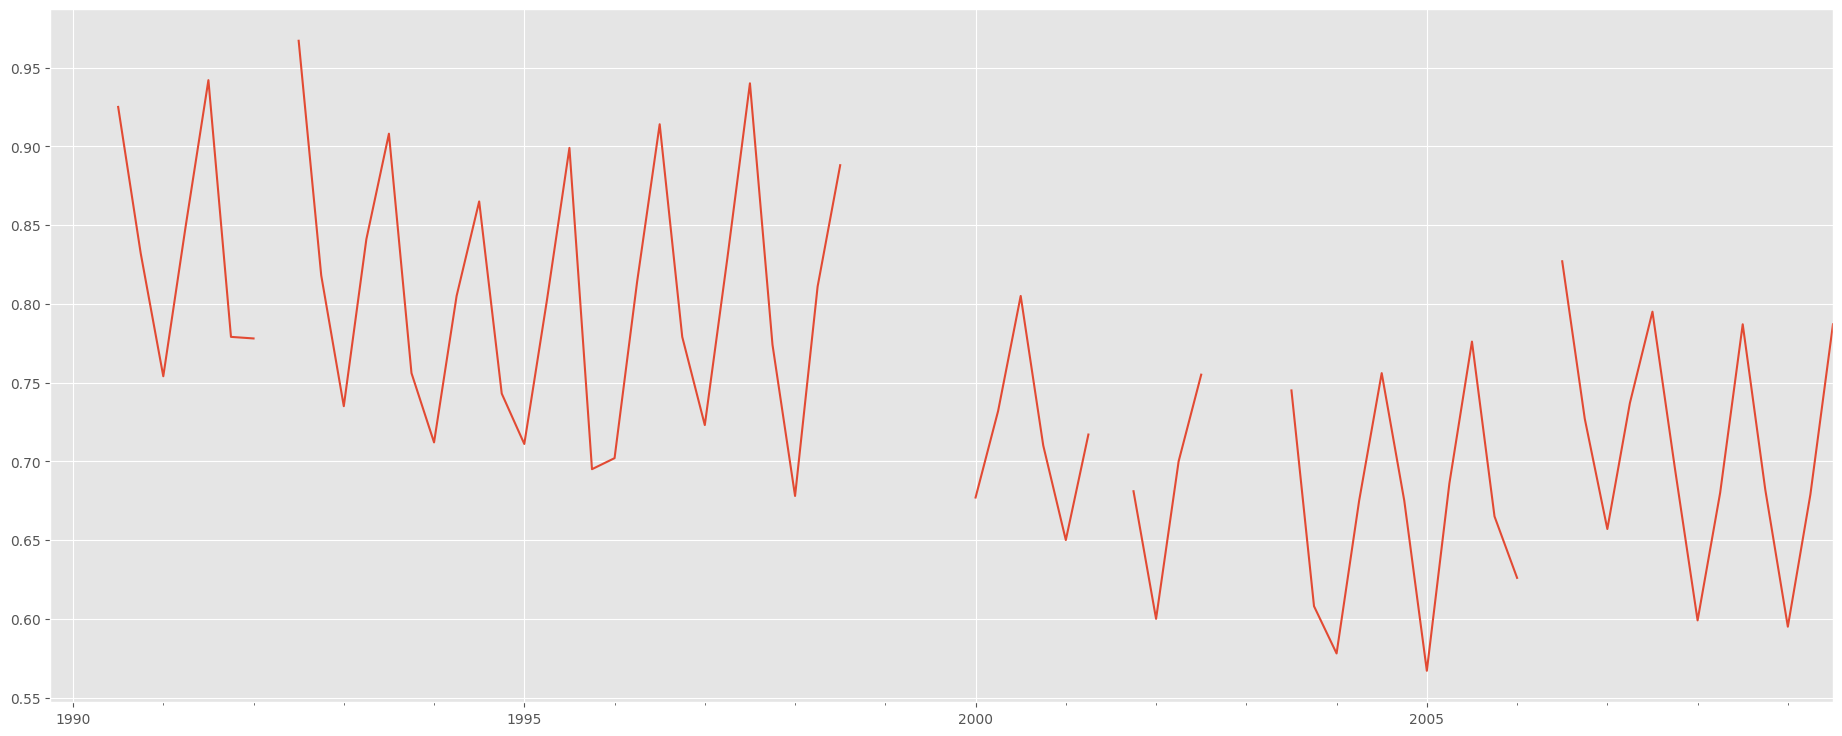

In [147]:
seasonal = macro.loc[:,'pop'].diff().dropna().tail(80).copy()

mask = np.random.binomial(1, 0.1, size=len(seasonal)) > 0 

seasonal_nan = seasonal.copy()
seasonal_nan[mask] = np.nan
seasonal_nan.plot()

previous = seasonal.shift(4)
future = seasonal.shift(-4)


# Усредним предудыщий и следующий периоды в аналогичном сезоне
seasonal_nan[seasonal_nan.isna()] = ((previous + future) / 2)[seasonal_nan.isna()]

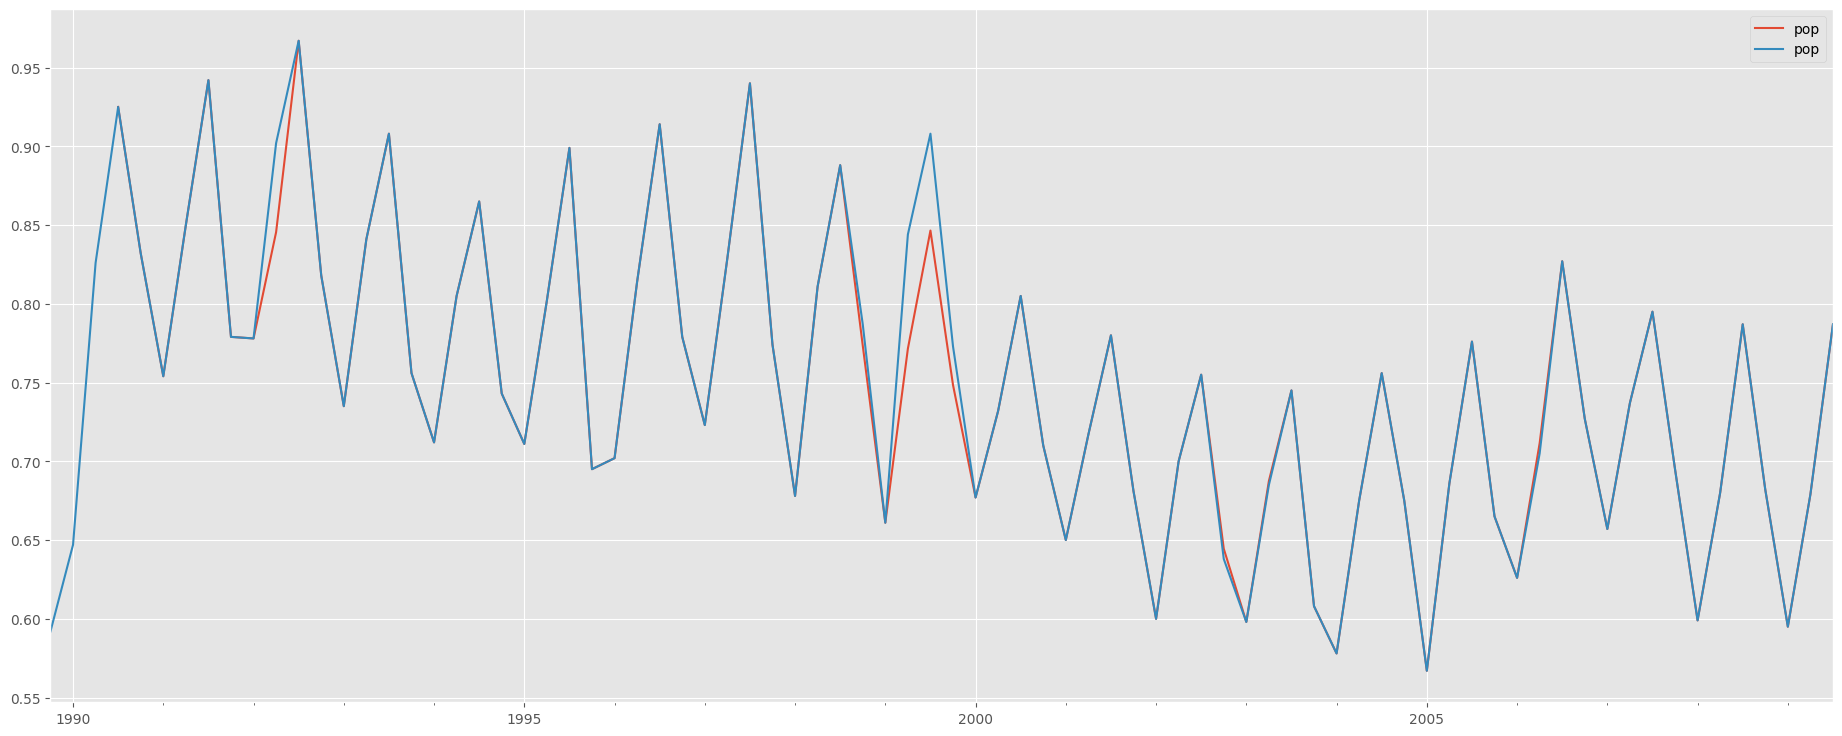

In [148]:
seasonal_nan.plot()
seasonal.plot()
plt.legend()

## Блок о том, почему наш курс не нужен

Первое о чём следует задуматься: а чем, собственно, ряды отличаются от стандартной задачи машинного обучений? Короткий ответ: особо ничем, но есть нюанс. В целом, задачу прогнозирования рядов можно решать как обычную табличную задачу. Сложность обычно в том, что под каждую задачу нужно отдельно возиться с генерацией признаков и порой простая модель временного ряда оказывается выразительнее кучи сгенерированныъ признаков. Сейчас мы попробуем повозиться немного с одной из таких задач. Данные взяты с [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv). Будем прогнозировать потребление электроэнергии в Испании.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor

from catboost import  CatBoostRegressor
from statsmodels.tsa.seasonal import STL, MSTL

import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# # Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


In [51]:
data

generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2015-01-01 00:00:00               447.0                                 329.0   
2015-01-01 01:00:00               449.0                                 328.0   
2015-01-01 02:00:00               448.0                                 323.0   
2015-01-01 03:00:00               438.0                                 254.0   
2015-01-01 04:00:00               428.0                                 187.0   
...                                 ...                                   ...   
2018-12-31 19:00:00               297.0                                   0.0   
2018-12-31 20:00:00               296.0                                   0.0   
2018-12-31 21:00:00               292.0                                   0.0   
2018-12-31 22:00:00               293.0                                   0.0   
2018-12-31 23:00:00               290.0                                   0.0   

                     generation fossil coal-derived gas  \
time                                                      
2015-01-01 00:00:00                                 0.0   
2015-01-01 01:00:00                                 0.0   
2015-01-01 02:00:00                                 0.0   
2015-01-01 03:00:00                                 0.0   
2015-01-01 04:00:00                                 0.0   
...                                                 ...   
2018-12-31 19:00:00                                 0.0   
2018-12-31 20:00:00                                 0.0   
2018-12-31 21:00:00                                 0.0   
2018-12-31 22:00:00                                 0.0   
2018-12-31 23:00:00                                 0.0   

                     generation fossil gas  generation fossil hard coal  \
time                                                                      
2015-01-01 00:00:00                 4844.0                       4821.0   
2015-01-01 01:00:00                 5196.0                       4755.0   
2015-01-01 02:00:00                 4857.0                       4581.0   
2015-01-01 03:00:00                 4314.0                       4131.0   
2015-01-01 04:00:00                 4130.0                       3840.0   
...                                    ...                          ...   
2018-12-31 19:00:00                 7634.0                       2628.0   
2018-12-31 20:00:00                 7241.0                       2566.0   
2018-12-31 21:00:00                 7025.0                       2422.0   
2018-12-31 22:00:00                 6562.0                       2293.0   
2018-12-31 23:00:00                 6926.0                       2166.0   

                     generation fossil oil  generation fossil oil shale  \
time                                                                      
2015-01-01 00:00:00                  162.0                          0.0   
2015-01-01 01:00:00                  158.0                          0.0   
2015-01-01 02:00:00                  157.0                          0.0   
2015-01-01 03:00:00                  160.0                          0.0   
2015-01-01 04:00:00                  156.0                          0.0   
...                                    ...                          ...   
2018-12-31 19:00:00                  178.0                          0.0   
2018-12-31 20:00:00                  174.0                          0.0   
2018-12-31 21:00:00                  168.0                          0.0   
2018-12-31 22:00:00                  163.0                          0.0   
2018-12-31 23:00:00                  163.0                          0.0   

                     generation fossil peat  generation geothermal  \
time                                                                 
2015-01-01 00:00:00                     0.0                    0.0   
2015-01-01 01:00:00                  

In [52]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.loc[:, 'dt_iso']= pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.loc[:, ['dt_iso', 'temp']]
# weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

weather

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')

In [53]:
target = data.loc[:,'total load actual'].resample('D').mean()

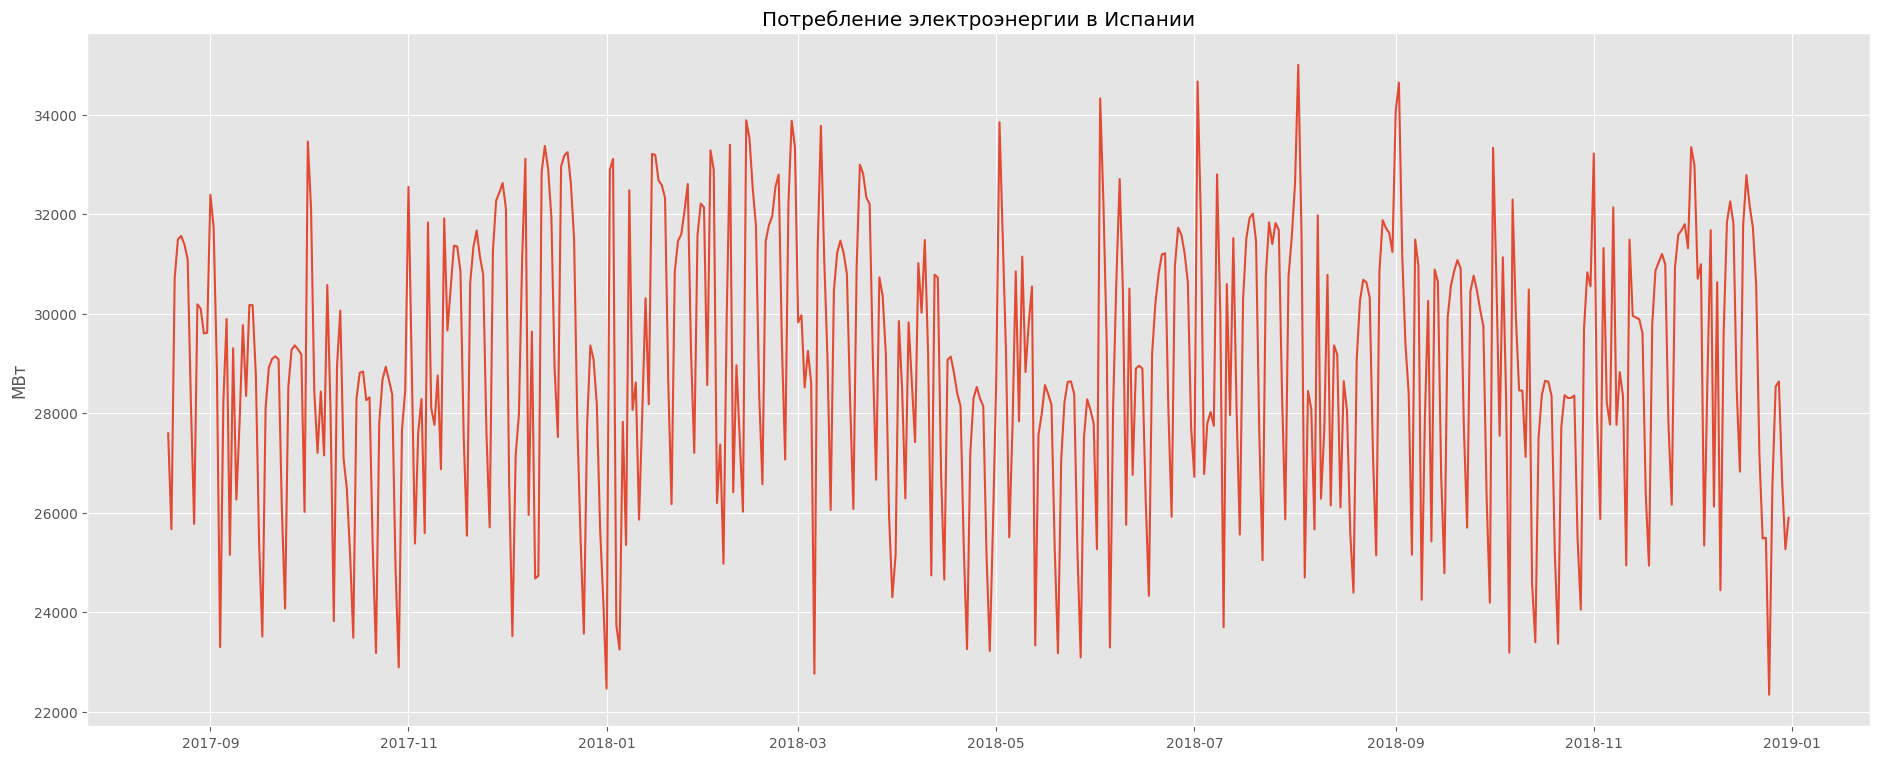

In [54]:
# Найти 
plt.plot(target.tail(500))
plt.title('Потребление электроэнергии в Испании')
plt.ylabel('МВт');

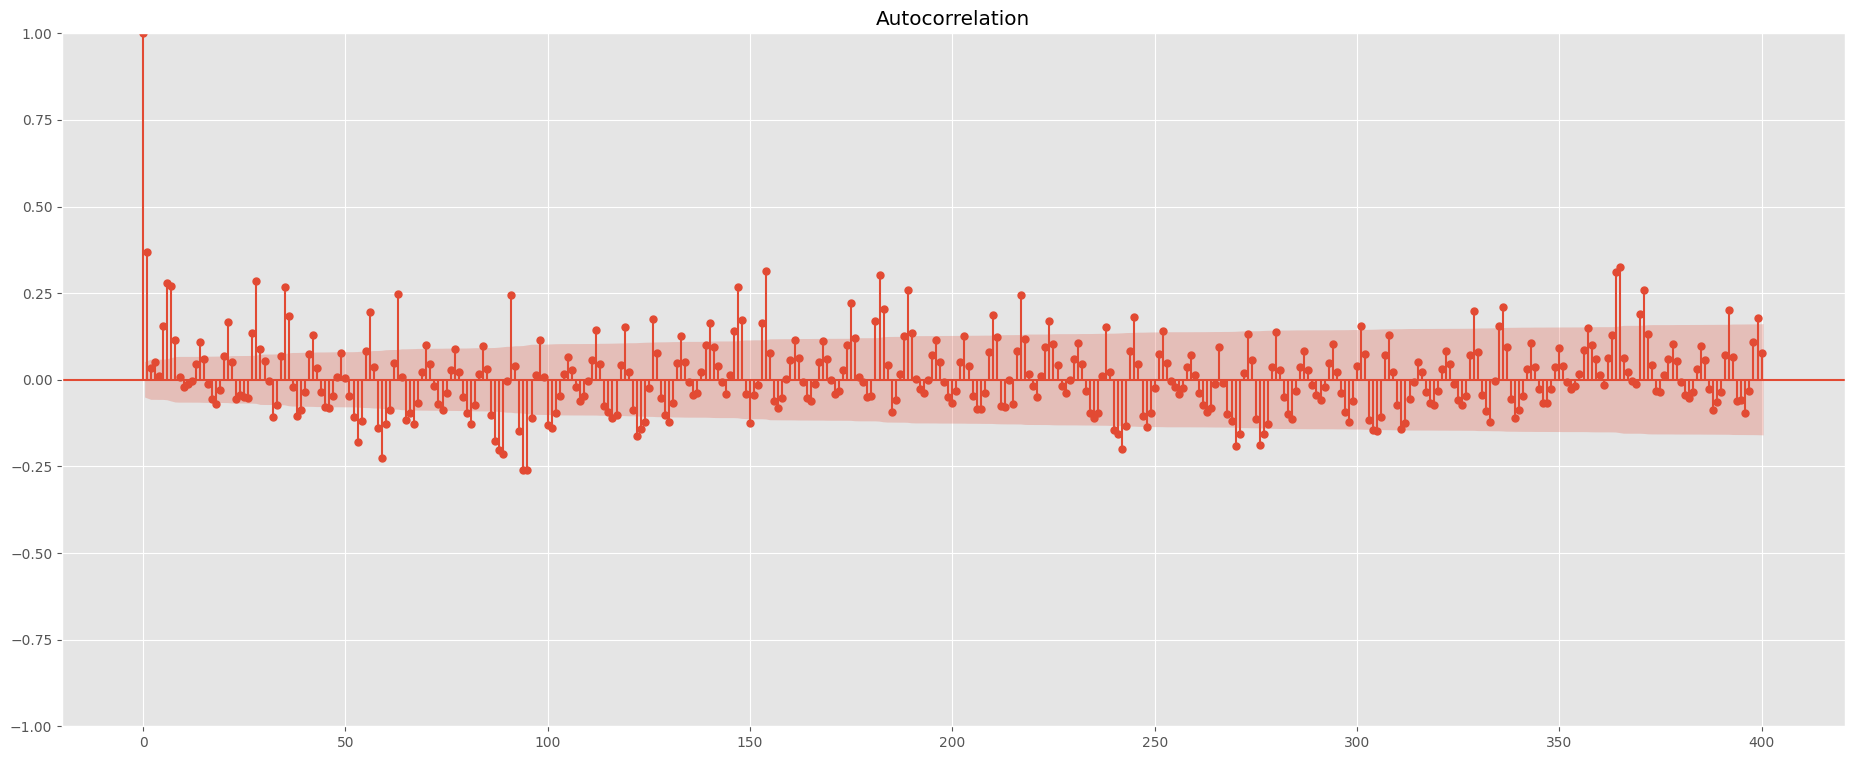

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(target, lags=400);

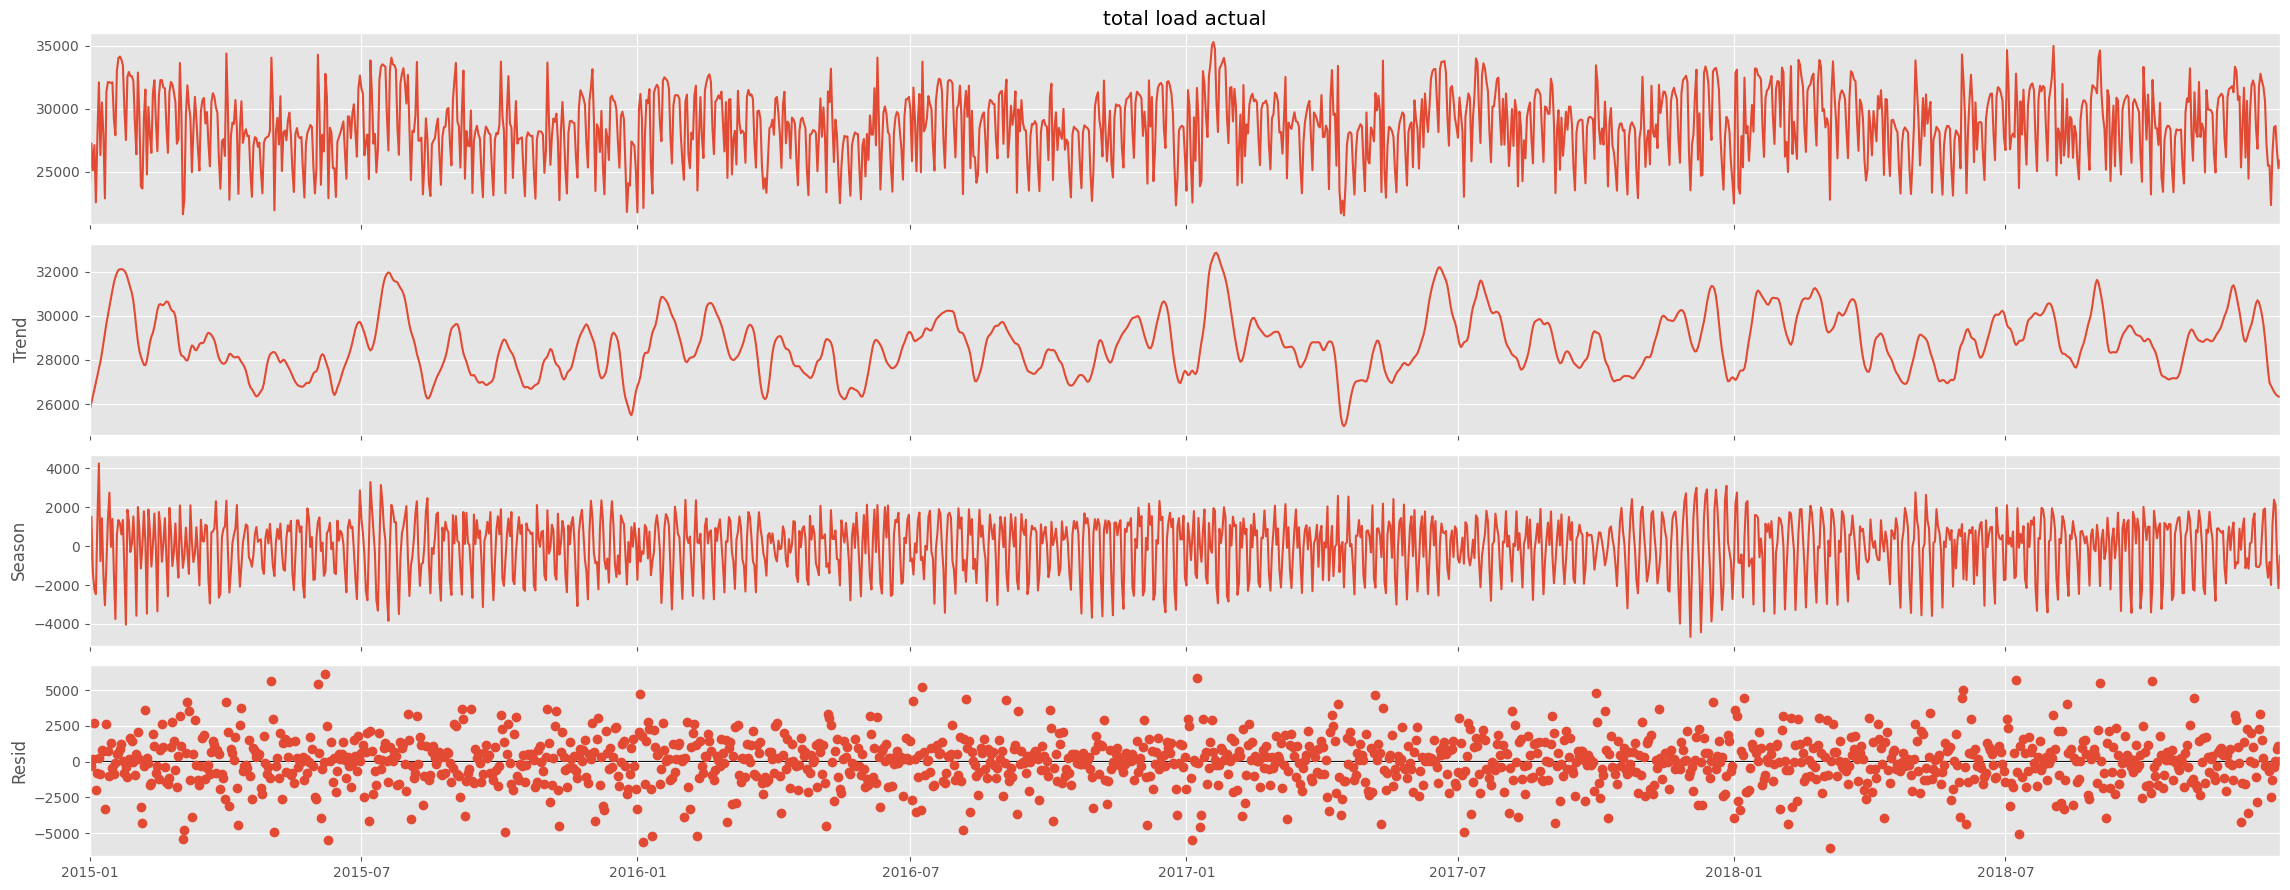

In [56]:
stl = STL(target, period=7)
res = stl.fit()
res.plot();

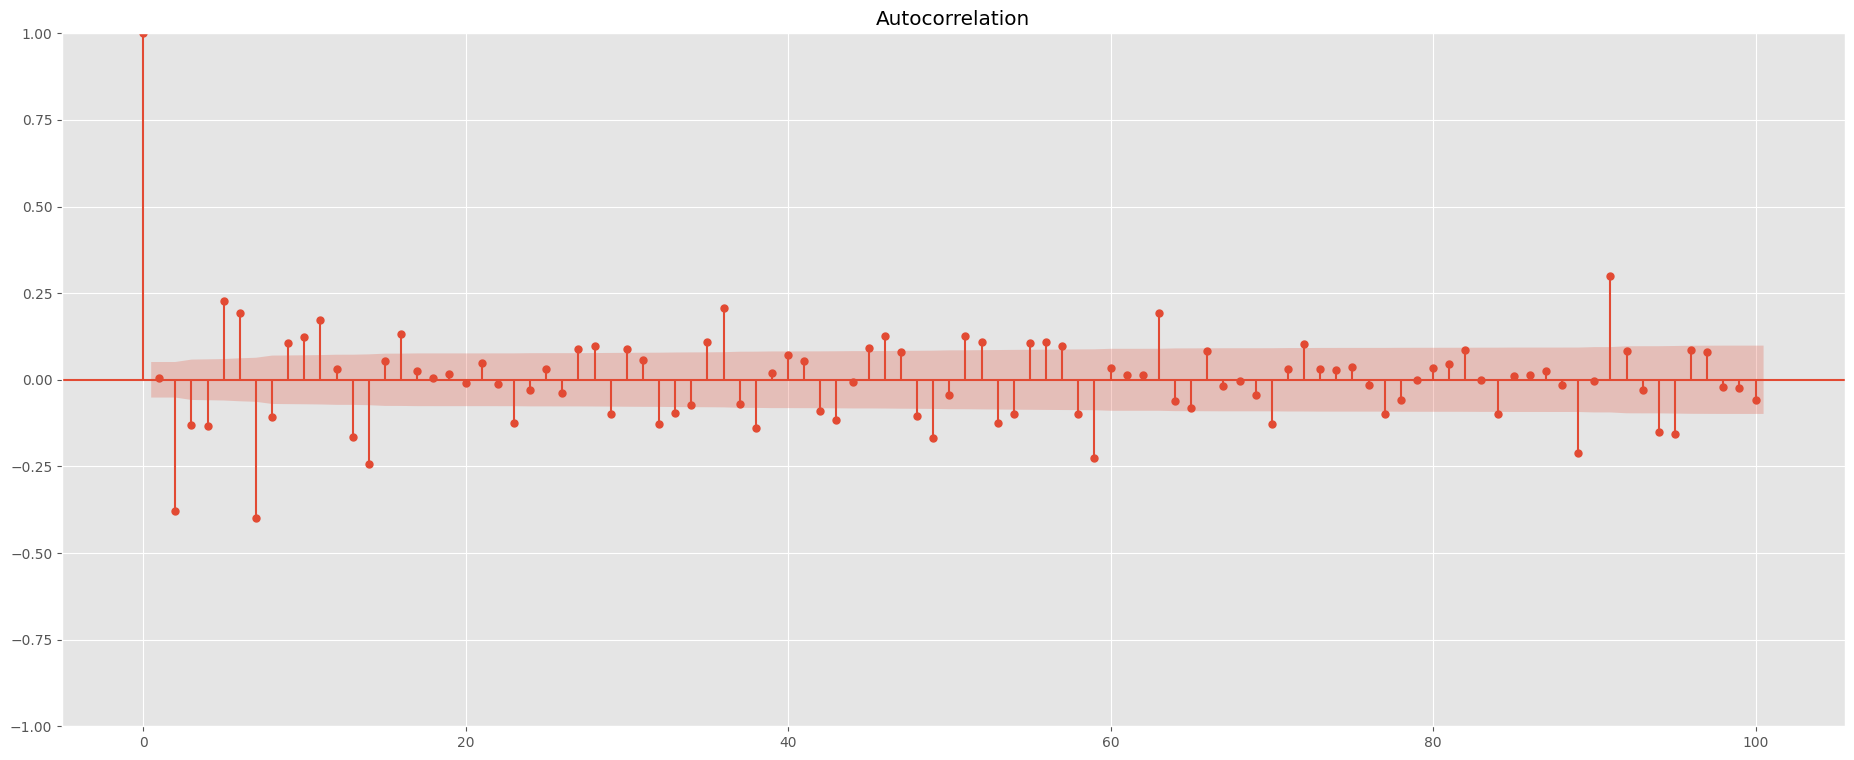

In [57]:
plot_acf(res.resid, lags=100);

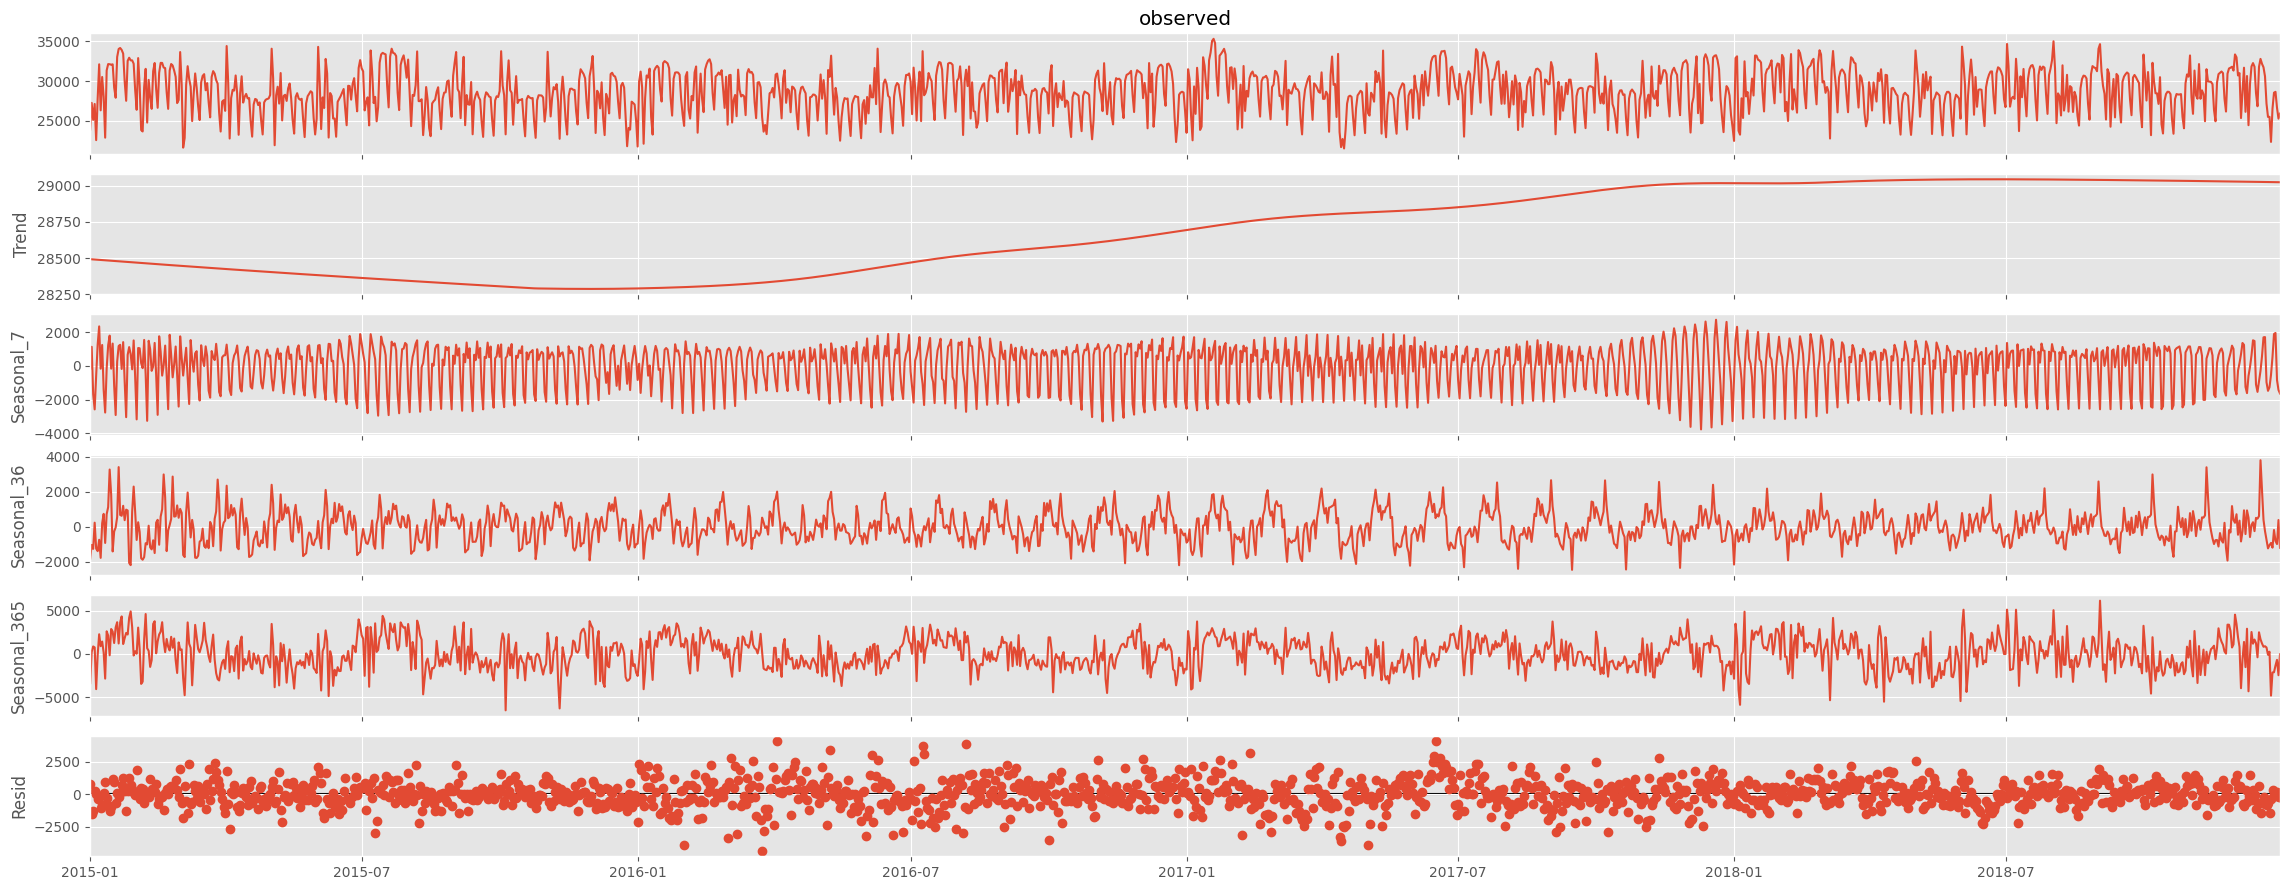

In [58]:
stl = MSTL(target, periods=[7, 36, 365])
res = stl.fit()
res.plot();

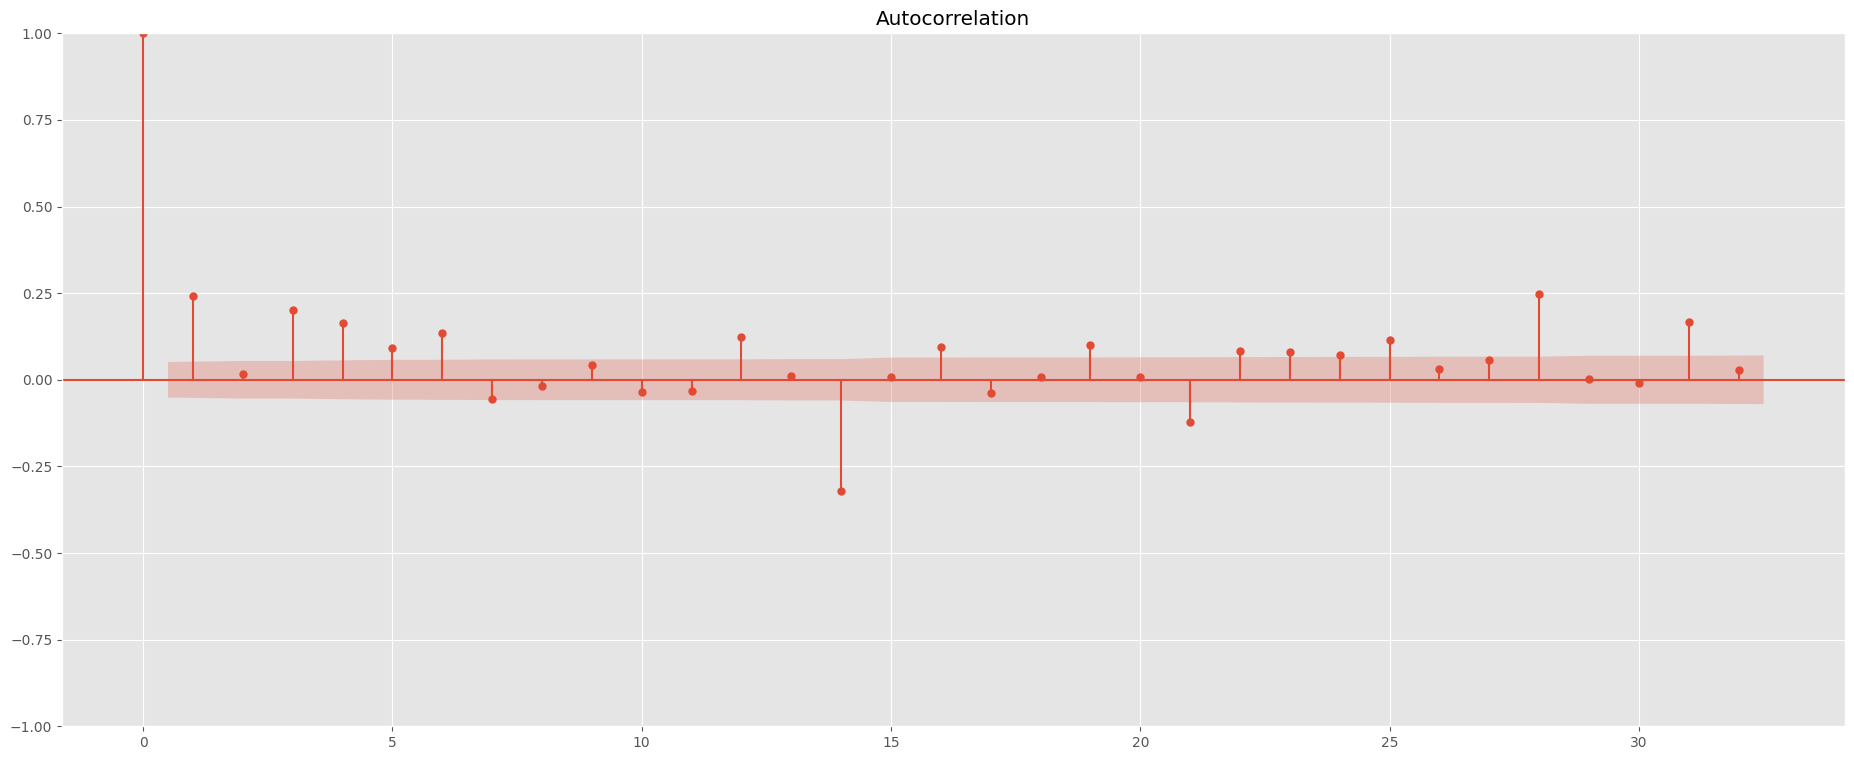

In [59]:
plot_acf(res.resid);

In [60]:
import holidays

es_holidays = holidays.Spain()

X = pd.DataFrame()

WINDOW = 7

X['target'] = data.loc[:,'total load actual'].resample('D').mean()

X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)

X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L31'] = X['target'].shift(31)

# X['y_L364'] = X['target'].shift(364)
# X['y_L365'] = X['target'].shift(365)
# X['y_L366'] = X['target'].shift(366)


X['diff_L1'] = X['target'].diff().shift(1)

X['rolling_mean'] = X['target'].rolling(WINDOW).mean().shift(1)


# X['month'] = X.index.month
X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.index.weekday >= 5
X['season'] = X.index.month%12 // 3 + 1


X['temp'] = data.loc[:,'temp'].resample('D').min() * (X.season == 1) \
        + data.loc[:,'temp'].resample('D').max() * (X.season == 3) \
        + data.loc[:,'temp'].resample('D').mean() * ((X.season == 2) | (X.season == 4))

# X['temp'] = X['temp'].shift(365)

# X['cos'] = np.cos((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))

t = (X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
t = np.arange(X.shape[0])+1
X['sin_7'] = np.sin(t * np.pi * 2 / 7)
X['cos_7'] = np.cos(t * np.pi * 2 / 7)

X['sin_365'] = np.sin(t * np.pi * 2 / 365)
X['cos_365'] = np.cos(t * np.pi * 2 / 365)


X['is_holiday'] = X.index.to_series().apply(lambda x: x in es_holidays)

In [61]:
X = X.dropna()

y = X.target
X = X.drop(columns=['target', "season"])

In [62]:


y_train, y_test, X_train, X_test = train_test_split(y, X, shuffle=False)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]

num_features = [col for col in X_train.columns if col not in cat_features and not (col.startswith("sin") or col.startswith("cos"))]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [63]:


model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.05129189869154682

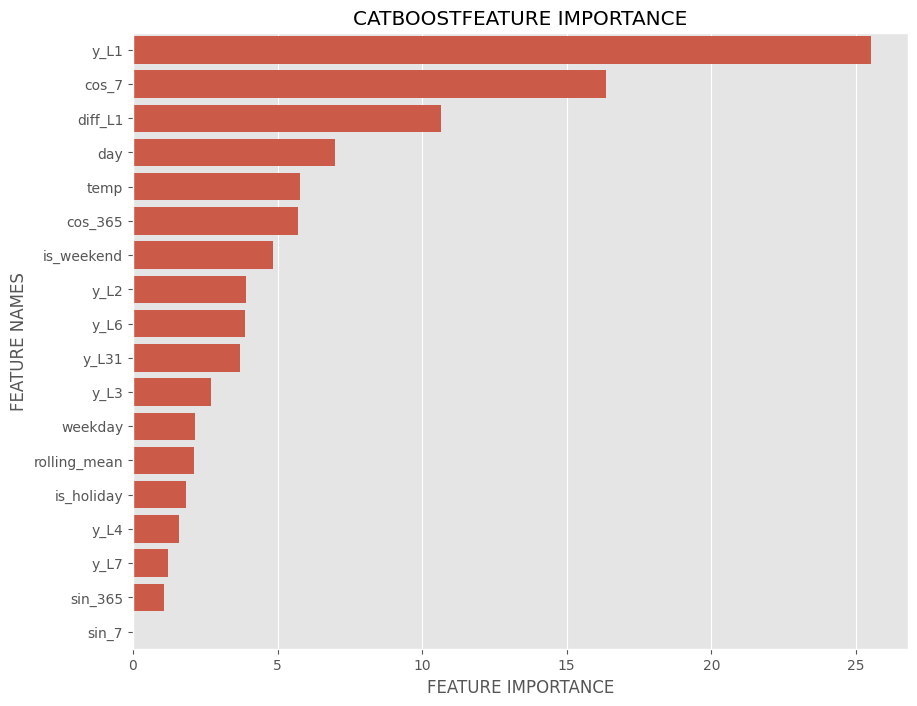

In [64]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),X.columns,'CATBOOST')

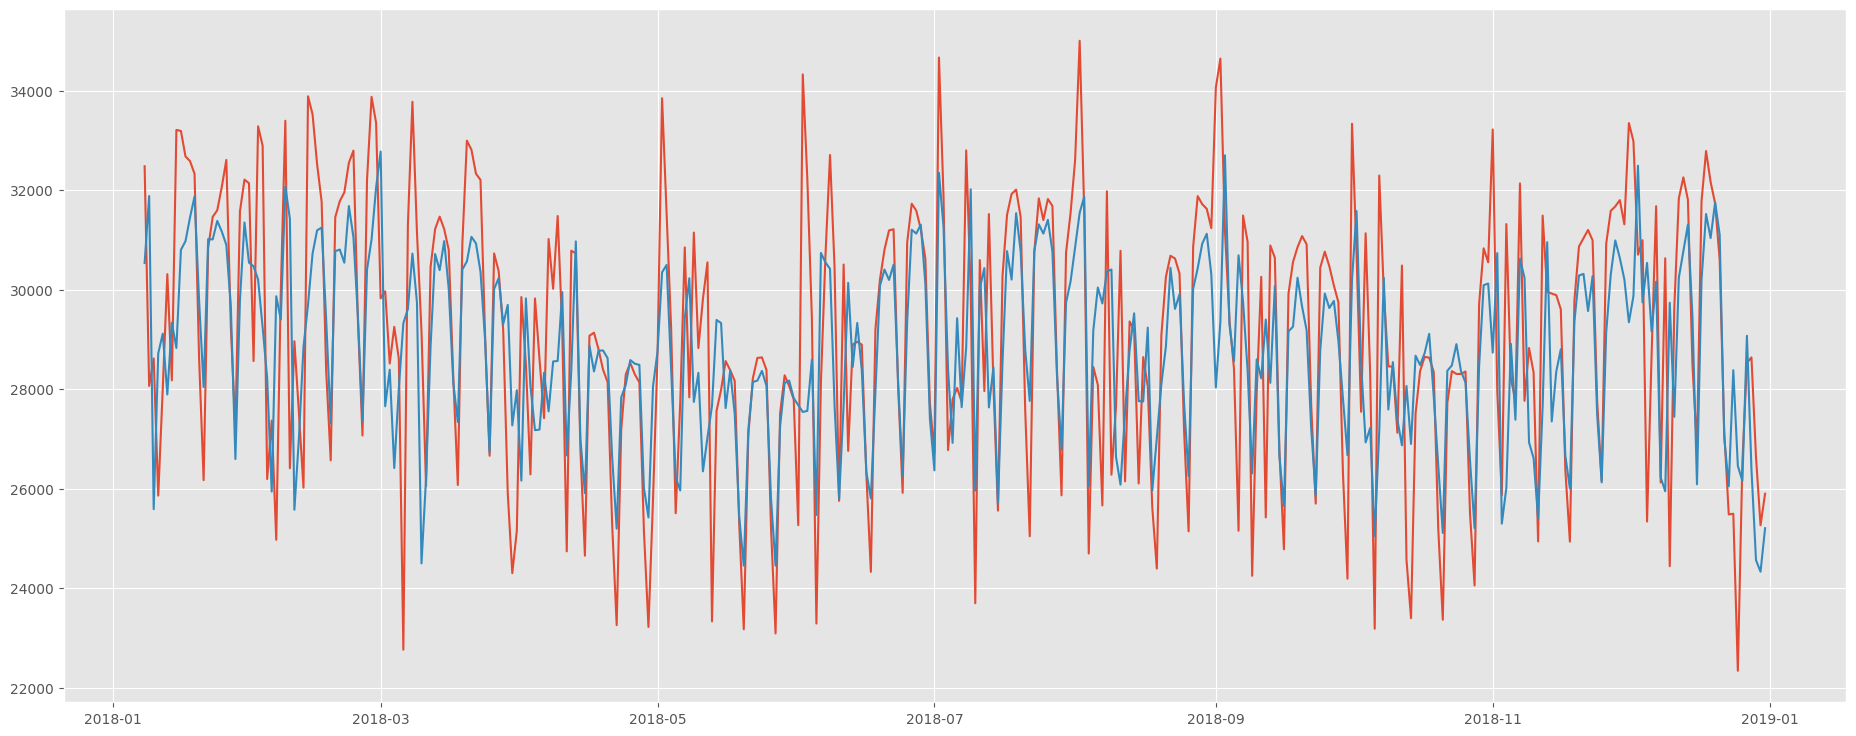

In [65]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)

In [69]:

mean_absolute_percentage_error(y_test, y_pred)

0.05129189869154682

In [72]:
# Качество наивной модели
mean_absolute_percentage_error(y_test, y.shift(1).tail(len(y_pred)))




0.08256356254180028